# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Import Libraries</p>

**This notebook is a guide and a collection of the best techniques I've been able to collect from others with personal additions of course; Ressources are given in the last section. I finished tenth(10th) in the competition standings (the leaderboard), which isn't too bad for a first-time participant in this type of competition.. From Exploratory Data Analysis to Model Building, everything is detailled. Do not hesitate to leave your remarks and comments**

In [1]:
!pip install sklego

import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV


# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklego.linear_model import LADRegression
from catboost import CatBoostRegressor


# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00


# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Import the data</p> 

In [2]:
# files path
train_path     = "/kaggle/input/playground-series-s3e16/train.csv"
test_path      = "/kaggle/input/playground-series-s3e16/test.csv"
original_path  = "/kaggle/input/crab-age-prediction/CrabAgePrediction.csv"
synthetic_path = "/kaggle/input/ps-s3-e16-synthetic-train-data/train_synthetic.csv"

# function to import our dataset 
def import_data(train_path, test_path, original_path, synthetic_path):
    train     =  pd.read_csv(train_path)
    test      =  pd.read_csv(test_path)
    original  =  pd.read_csv(original_path)
    synthetic =  pd.read_csv(synthetic_path)
    
    return train, test, original, synthetic

train, test, original, synthetic = import_data(train_path, test_path, original_path, synthetic_path)

The train dataset is a synthetic dataset generated from the [Crab Age Prediction](https://www.kaggle.com/datasets/sidhus/crab-age-prediction) dataset(original). These are the descriptions of the variables in this dataset:

<ul>
<li> Sex: Gender of the Crab - Male, Female and Indeterminate </li>
<li> Length: Length of the Crab in feet </li>
<li> Diameter: Diameter of the Crab in feet </li>
<li> Height: Height of the Crab in feet </li>
<li> Weight: Weight of the Crab in ounces </li>
<li> Shucked Weight: Weight without the shell in ounces </li>
<li> Viscera Weight: Weight that wraps around the crab's abdominal organs in ounces </li>
<li> Shell Weight: Weight of the Shell in ounces </li>
<li> Age: Age of the Crab in months</li>


<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
In addition to the train and original datasets, I've imported another synthetic dataset. You can find the link to it in the end of this notebook.   
Anyway, let’s take a look at the Data Structure
</b>
</p> 

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Exploratory Data Analysis - EDA</p> 

In [3]:
train.head(3)

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750   0.375  28.973189       12.728926   
1   1   I  1.1000    0.8250   0.275  10.418441        4.521745   
2   2   M  1.3875    1.1125   0.375  24.777463       11.339800   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9

In [4]:
original.head(3)

Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0   F  1.4375     1.175  0.4125  24.635715       12.332033        5.584852   
1   M  0.8875     0.650  0.2125   5.400580        2.296310        1.374951   
2   I  1.0375     0.775  0.2500   7.952035        3.231843        1.601747   

   Shell Weight  Age  
0      6.747181    9  
1      1.559222    6  
2      2.764076    6

In [5]:
synthetic.head(3)

id Sex  Length  Diameter  Height    Weight  Shucked Weight  Viscera Weight  \
0   0   I  0.7000    0.6000  0.2000  4.493396        1.346601        0.864660   
1   1   I  0.9375    0.7000  0.2250  8.178831        3.983105        1.545048   
2   2   I  0.8250    0.6375  0.2125  5.301356        2.438057        1.445825   

   Shell Weight  Age  
0      1.204854    5  
1      2.551455    6  
2      1.644271    6

In [6]:
test.head(3)

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0  74051   I  1.0500    0.7625   0.275   8.618248        3.657085   
1  74052   I  1.1625    0.8875   0.275  15.507176        7.030676   
2  74053   F  1.2875    0.9875   0.325  14.571643        5.556502   

   Viscera Weight  Shell Weight  
0        1.729319      2.721552  
1        3.246018      3.968930  
2        3.883882      4.819415

Now, we'll try to use some descriptive statistics

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">1. Univariate Statistics</p> 

We can use the .describe() method from pandas to see basic stats like count, mean, standard deviation, minimum, maximum, quantiles...

In [7]:
train.describe().T

count          mean           std       min           25%  \
id              74051.0  37025.000000  21376.826729  0.000000  18512.500000   
Length          74051.0      1.317460      0.287757  0.187500      1.150000   
Diameter        74051.0      1.024496      0.237396  0.137500      0.887500   
Height          74051.0      0.348089      0.092034  0.000000      0.300000   
Weight          74051.0     23.385217     12.648153  0.056699     13.437663   
Shucked Weight  74051.0     10.104270      5.618025  0.028349      5.712424   
Viscera Weight  74051.0      5.058386      2.792729  0.042524      2.863300   
Shell Weight    74051.0      6.723870      3.584372  0.042524      3.968930   
Age             74051.0      9.967806      3.175189  1.000000      8.000000   

                         50%           75%           max  
id              37025.000000  55537.500000  74050.000000  
Length              1.375000      1.537500      2.012815  
Diameter            1.075000      1.200000      1.612500  
Height              0.362500      0.412500      2.825000  
Weight             23.799405     32.162508     80.101512  
Shucked Weight      9.908150     14.033003     42.184056  
Viscera Weight      4.989512      6.988152     21.545620  
Shell Weight        6.931453      9.071840     28.491248  
Age                10.000000     11.000000     29.000000

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
From the count column we can see that there is no missing values in our train dataset. This sounds good ;) <br>
Let's be sure about this assumption for the test, original and synthetic datasets. <br>
To achieve this, we will define our own function for univariate statistics with more informations such as the mode, skewness, kurtosis...
</b>
</p> 

In [8]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [9]:
# Call the function on train
univariate_stats(train)

Count  Missing  Unique    Dtype  IsNumeric       Mode  \
id              74051        0   74051    int64       True          0   
Weight          74051        0    3096  float64       True  32.162508   
Shucked Weight  74051        0    1766  float64       True   9.879801   
Shell Weight    74051        0    1048  float64       True   7.796112   
Viscera Weight  74051        0     967  float64       True   5.868347   
Length          74051        0     144  float64       True     1.5625   
Diameter        74051        0     122  float64       True      1.125   
Height          74051        0      65  float64       True      0.375   
Age             74051        0      28    int64       True          9   
Sex             74051        0       3   object      False          M   

                     Mean       Min        25%     Median        75%  \
id                37025.0         0    18512.5    37025.0    55537.5   
Weight          23.385217  0.056699  13.437663  23.799405  32.162508   
Shucked Weight   10.10427  0.028349   5.712424    9.90815  14.033003   
Shell Weight      6.72387  0.042524    3.96893   6.931453    9.07184   
Viscera Weight   5.058386  0.042524     2.8633   4.989512   6.988152   
Length            1.31746    0.1875       1.15      1.375     1.5375   
Diameter         1.024496    0.1375     0.8875      1.075        1.2   
Height           0.348089       0.0        0.3     0.3625     0.4125   
Age              9.967806         1        8.0       10.0       11.0   
Sex                     -         -          -          -          -   

                      Max           Std      Skew       Kurt  
id                  74050  21376.826729       0.0       -1.2  
Weight          80.101512     12.648153  0.231465  -0.401799  
Shucked Weight  42.184056      5.618025  0.349472  -0.119074  
Shell Weight    28.491248      3.584372  0.277459  -0.142415  
Viscera Weight   21.54562      2.792729  0.286383  -0.365303  
Length           2.012815      0.287757 -0.844377   0.291767  
Diameter           1.6125      0.237396 -0.812866   0.177278  
Height              2.825      0.092034  0.086578  14.153342  
Age                    29      3.175189  1.092919   2.296641  
Sex                     -             -         -          -

In [10]:
# Call the function to check univariate stats on the original dataset
univariate_stats(original)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
Weight           3893        0    2343  float64       True  5.556502   
Shucked Weight   3893        0    1482  float64       True  4.961163   
Shell Weight     3893        0     907  float64       True  7.796112   
Viscera Weight   3893        0     867  float64       True  4.861939   
Length           3893        0     134  float64       True    1.5625   
Diameter         3893        0     111  float64       True     1.125   
Height           3893        0      51  float64       True     0.375   
Age              3893        0      28    int64       True         9   
Sex              3893        0       3   object      False         M   

                     Mean       Min        25%     Median        75%  \
Weight          23.567275  0.056699  12.672227  22.792998  32.786197   
Shucked Weight  10.207342  0.028349   5.343881   9.539607  14.273973   
Shell Weight     6.795844  0.042524   3.713785   6.662133   9.355335   
Viscera Weight   5.136546  0.014175   2.664853   4.861939   7.200773   
Length           1.311306    0.1875      1.125     1.3625     1.5375   
Diameter         1.020893    0.1375      0.875     1.0625        1.2   
Height           0.349374       0.0     0.2875     0.3625     0.4125   
Age              9.954791         1        8.0       10.0       11.0   
Sex                     -         -          -          -          -   

                      Max        Std      Skew       Kurt  
Weight          80.101512  13.891201  0.518903  -0.023172  
Shucked Weight  42.184056   6.275275  0.703114    0.57945  
Shell Weight    28.491248   3.943392  0.607716   0.517478  
Viscera Weight   21.54562   3.104133   0.57829   0.088392  
Length             2.0375   0.300431 -0.651111   0.077475  
Diameter            1.625   0.248233 -0.617403  -0.040666  
Height              2.825   0.104976  3.314345  80.253588  
Age                    29   3.220967   1.10471   2.335614  
Sex                     -          -         -          -

In [11]:
# Call the function to check univariate stats on test dataset
univariate_stats(test)

Count  Missing  Unique    Dtype  IsNumeric       Mode  \
id              49368        0   49368    int64       True      74051   
Weight          49368        0    2948  float64       True  32.162508   
Shucked Weight  49368        0    1692  float64       True   9.879801   
Shell Weight    49368        0     987  float64       True   8.930093   
Viscera Weight  49368        0     938  float64       True   5.868347   
Length          49368        0     140  float64       True     1.5625   
Diameter        49368        0     122  float64       True      1.125   
Height          49368        0      57  float64       True      0.375   
Sex             49368        0       3   object      False          M   

                     Mean       Min        25%    Median        75%  \
id                98734.5     74051   86392.75   98734.5  111076.25   
Weight          23.464627  0.056699  13.536886  23.81358  32.290081   
Shucked Weight   10.13022  0.028349   5.740774  9.979024  14.047177   
Shell Weight     6.745876  0.042524    3.96893  6.945627   9.171063   
Viscera Weight   5.072615  0.014175   2.877474  4.989512   7.016501   
Length           1.319795    0.1875     1.1625    1.3875     1.5375   
Diameter         1.026357    0.1375     0.8875     1.075        1.2   
Height           0.348693       0.0        0.3    0.3625     0.4125   
Sex                     -         -          -         -          -   

                      Max           Std      Skew       Kurt  
id                 123418  14251.458382       0.0       -1.2  
Weight          80.101512     12.641703  0.232137  -0.374375  
Shucked Weight  42.184056      5.611779  0.356356  -0.051306  
Shell Weight    28.491248       3.57565  0.274145  -0.114712  
Viscera Weight   21.54562      2.791563  0.285361   -0.37178  
Length             2.0375       0.28695 -0.854461   0.319099  
Diameter            1.625      0.236593 -0.821957   0.206667  
Height              2.825      0.092259  0.343451  21.039298  
Sex                     -             -         -          -

In [12]:
# Call the function to check univariate stats on synthetic dataset
univariate_stats(synthetic)

Count  Missing  Unique    Dtype  IsNumeric       Mode  \
id              123395        0  123395    int64       True          0   
Weight          123395        0    3285  float64       True  32.162508   
Shucked Weight  123395        0    1872  float64       True   2.721552   
Shell Weight    123395        0    1044  float64       True   8.930093   
Viscera Weight  123395        0    1000  float64       True   4.861939   
Length          123395        0     150  float64       True     1.5625   
Diameter        123395        0     120  float64       True      1.125   
Height          123395        0      62  float64       True      0.375   
Age             123395        0      28    int64       True          9   
Sex             123395        0       3   object      False          M   

                     Mean       Min        25%     Median        75%  \
id                61697.0         0    30848.5    61697.0    92545.5   
Weight          23.156335  0.042524  13.111644  23.586784  32.105809   
Shucked Weight     9.9996  0.014175     5.6699   9.865626  13.933779   
Shell Weight     6.647467  0.042524   3.827183    6.80388    9.07184   
Viscera Weight   5.000547  0.014175   2.792426   4.890289   6.959802   
Length           1.313082    0.1875       1.15      1.375      1.525   
Diameter         1.020951    0.0875      0.875      1.075        1.2   
Height           0.346165       0.0     0.2875     0.3625     0.4125   
Age              9.947145         1        8.0       10.0       11.0   
Sex                     -         -          -          -          -   

                      Max           Std      Skew      Kurt  
id                 123394  35621.212571       0.0      -1.2  
Weight          80.101512     12.629364   0.24296 -0.408026  
Shucked Weight  38.966388      5.608705  0.380783  -0.07293  
Shell Weight    32.786197      3.571294  0.275639 -0.209902  
Viscera Weight  18.200379      2.794028   0.30413 -0.403621  
Length           2.764076      0.289462 -0.834398   0.26786  
Diameter            1.625      0.238656 -0.803978  0.150899  
Height           2.353009      0.091447  -0.37523  2.296064  
Age                    29      3.220535  1.106162  2.335189  
Sex                     -             -         -         -

In [13]:
# List of numerical columns and categorical columns

numeric_cols = train.select_dtypes(include=['float64']).columns.tolist()
categ_cols   = train.select_dtypes(include=['object']).columns.tolist()
target       = 'Age'
numeric_cols
categ_cols

['Sex']

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
Let's visualize some graphics to gain more insights. <br>
        <br><br>
PS : Don't care about the graphics of the id column. We'll remove it in the feature engineering part ;)
</b>
</p> 

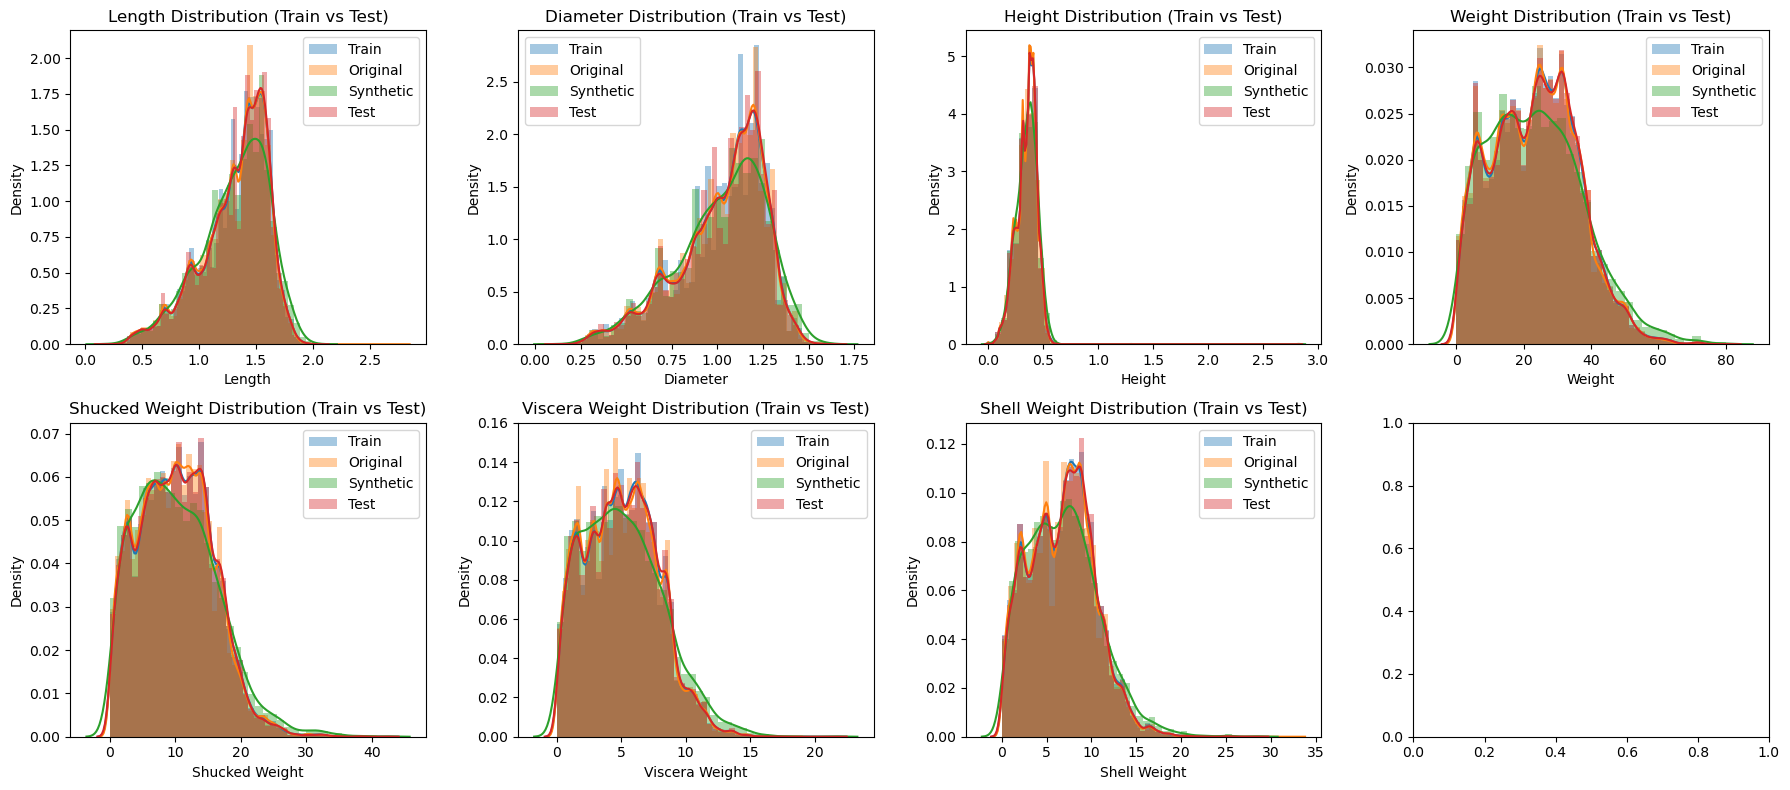

In [14]:
def plot_histograms(df_train, df_test, original, synthetic,target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')      # plot train data
        sns.distplot(original[var_name], kde=True, ax=ax, label='Original')   # plot original data
        sns.distplot(synthetic[var_name], kde=True, ax=ax, label='Synthetic')   # plot original data
        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')    # plot test data
        
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train[numeric_cols], test[numeric_cols], synthetic, original[numeric_cols], target, n_cols=4)

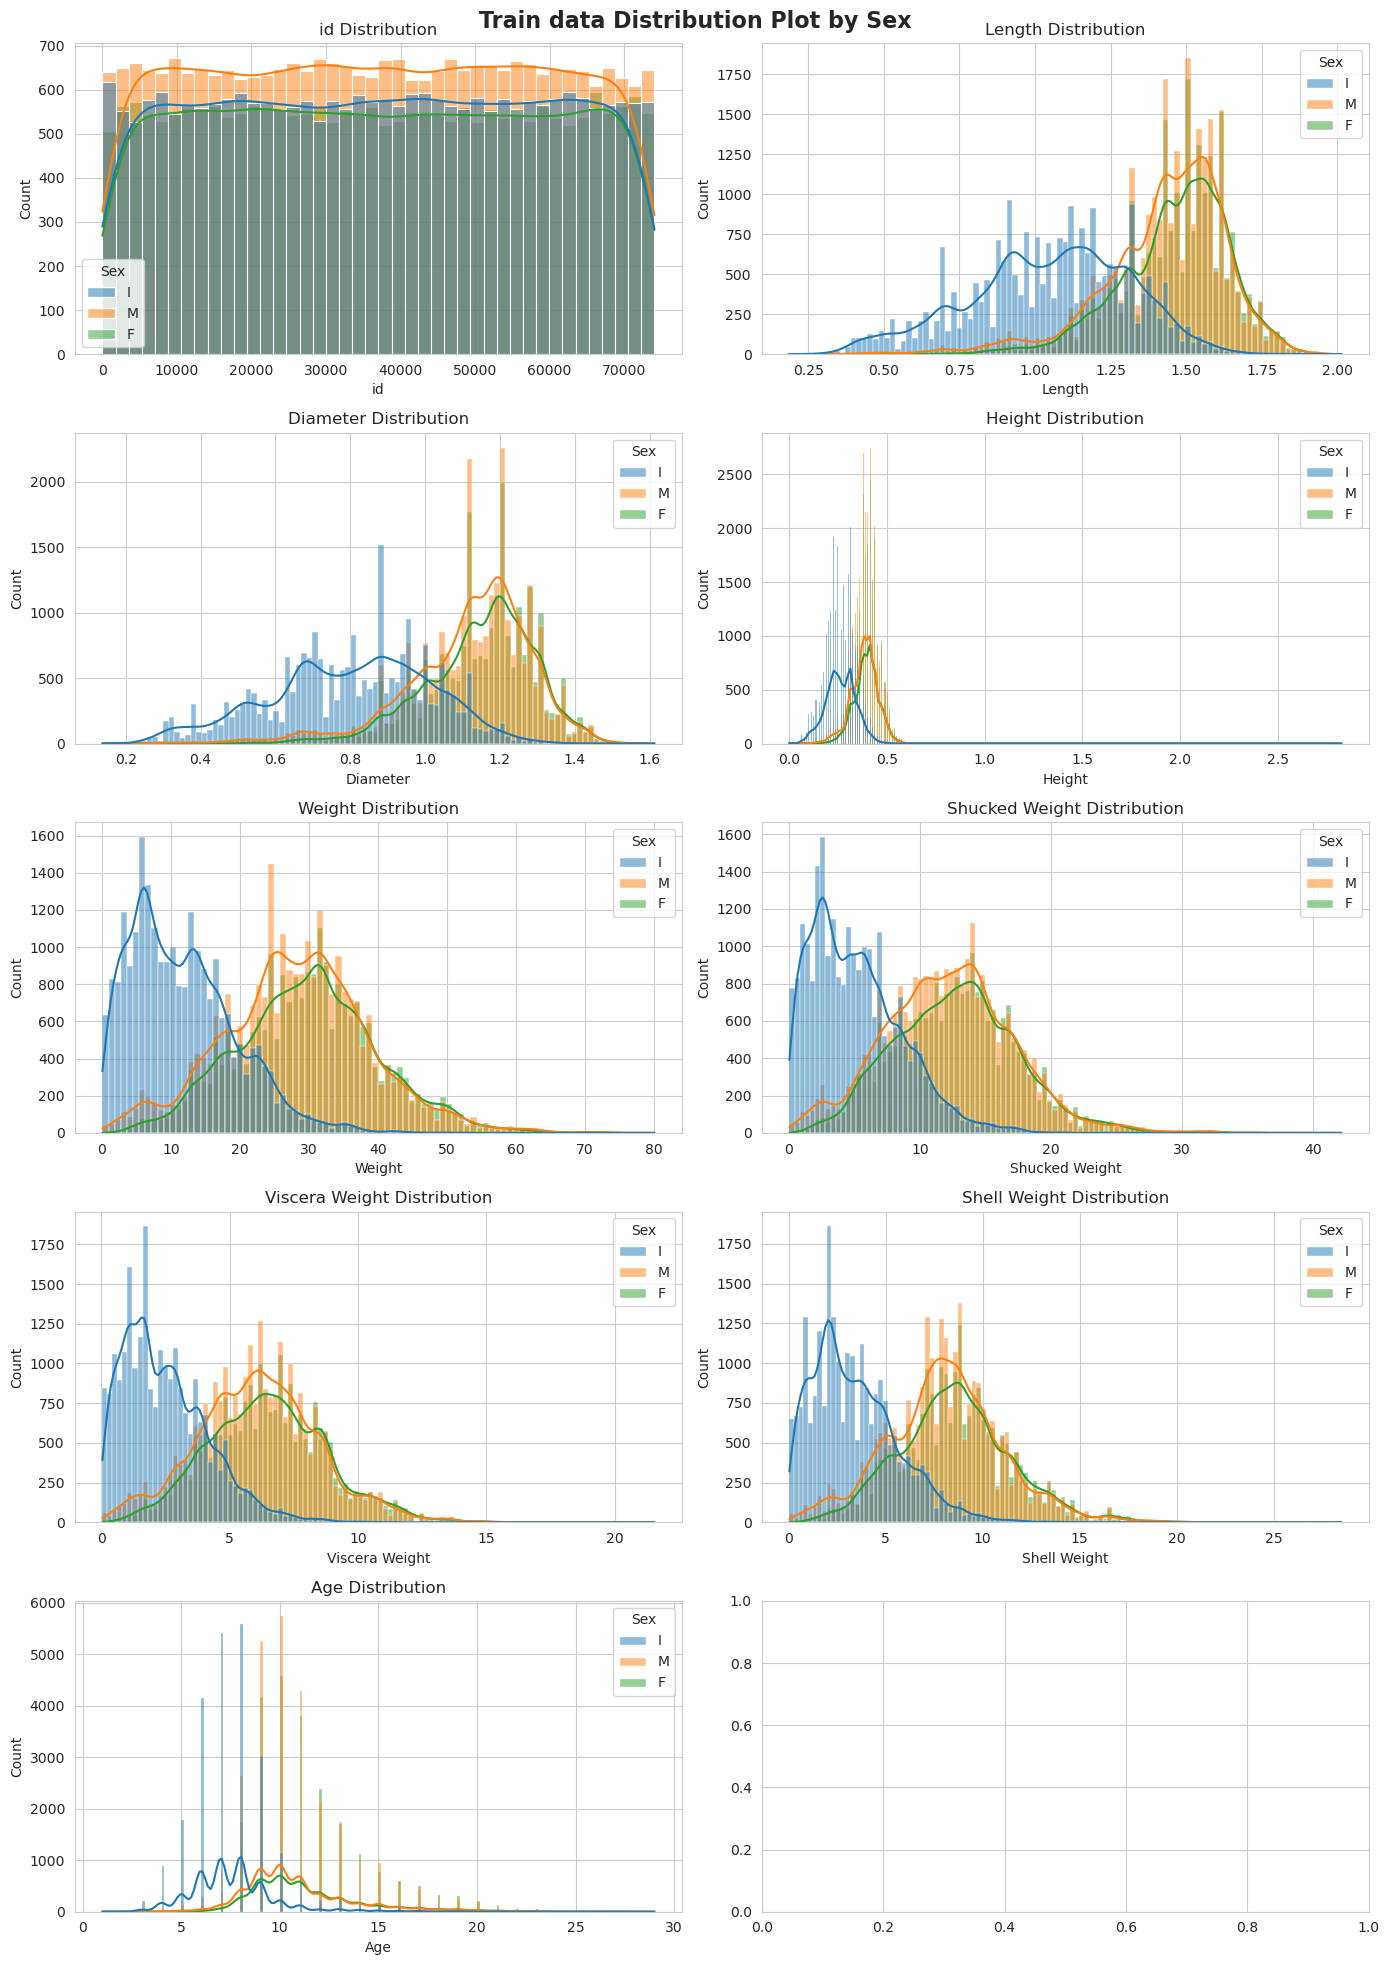

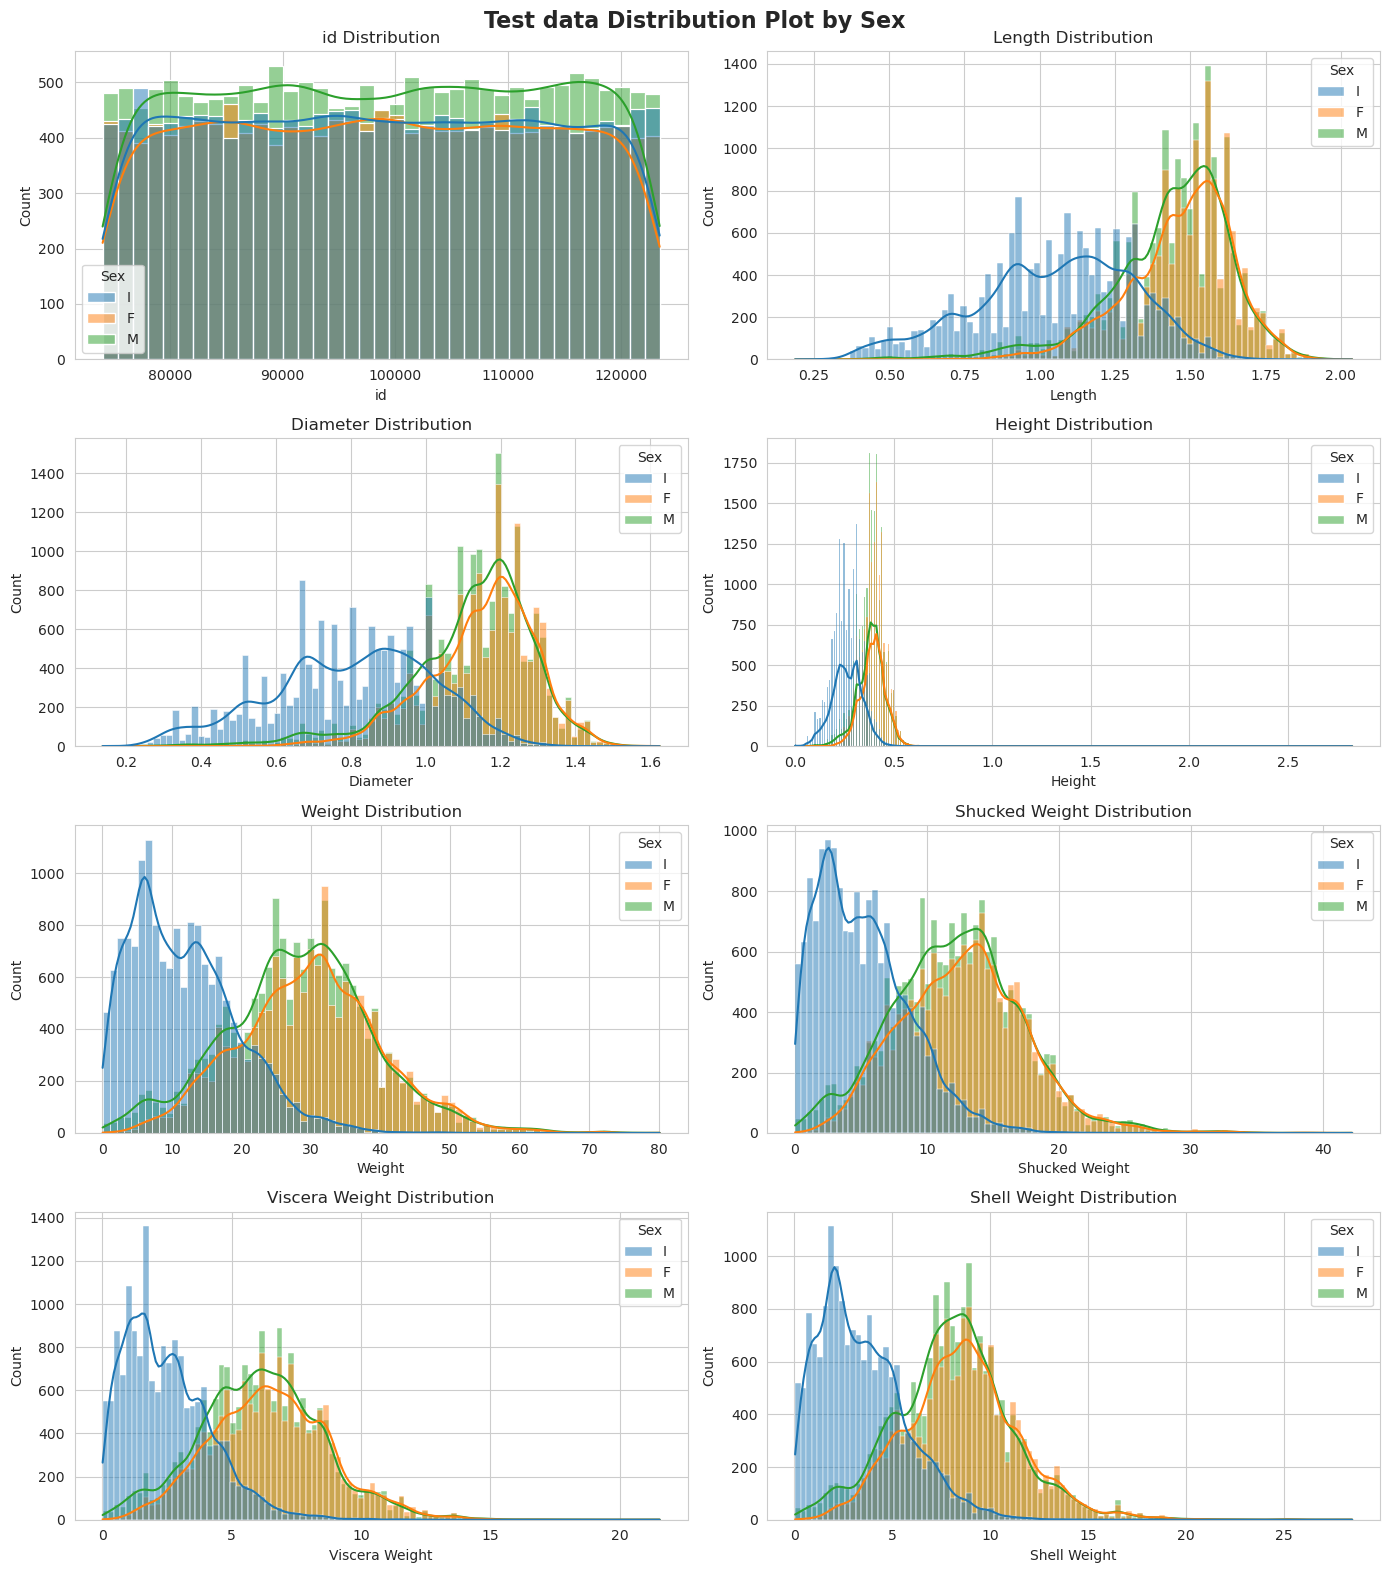

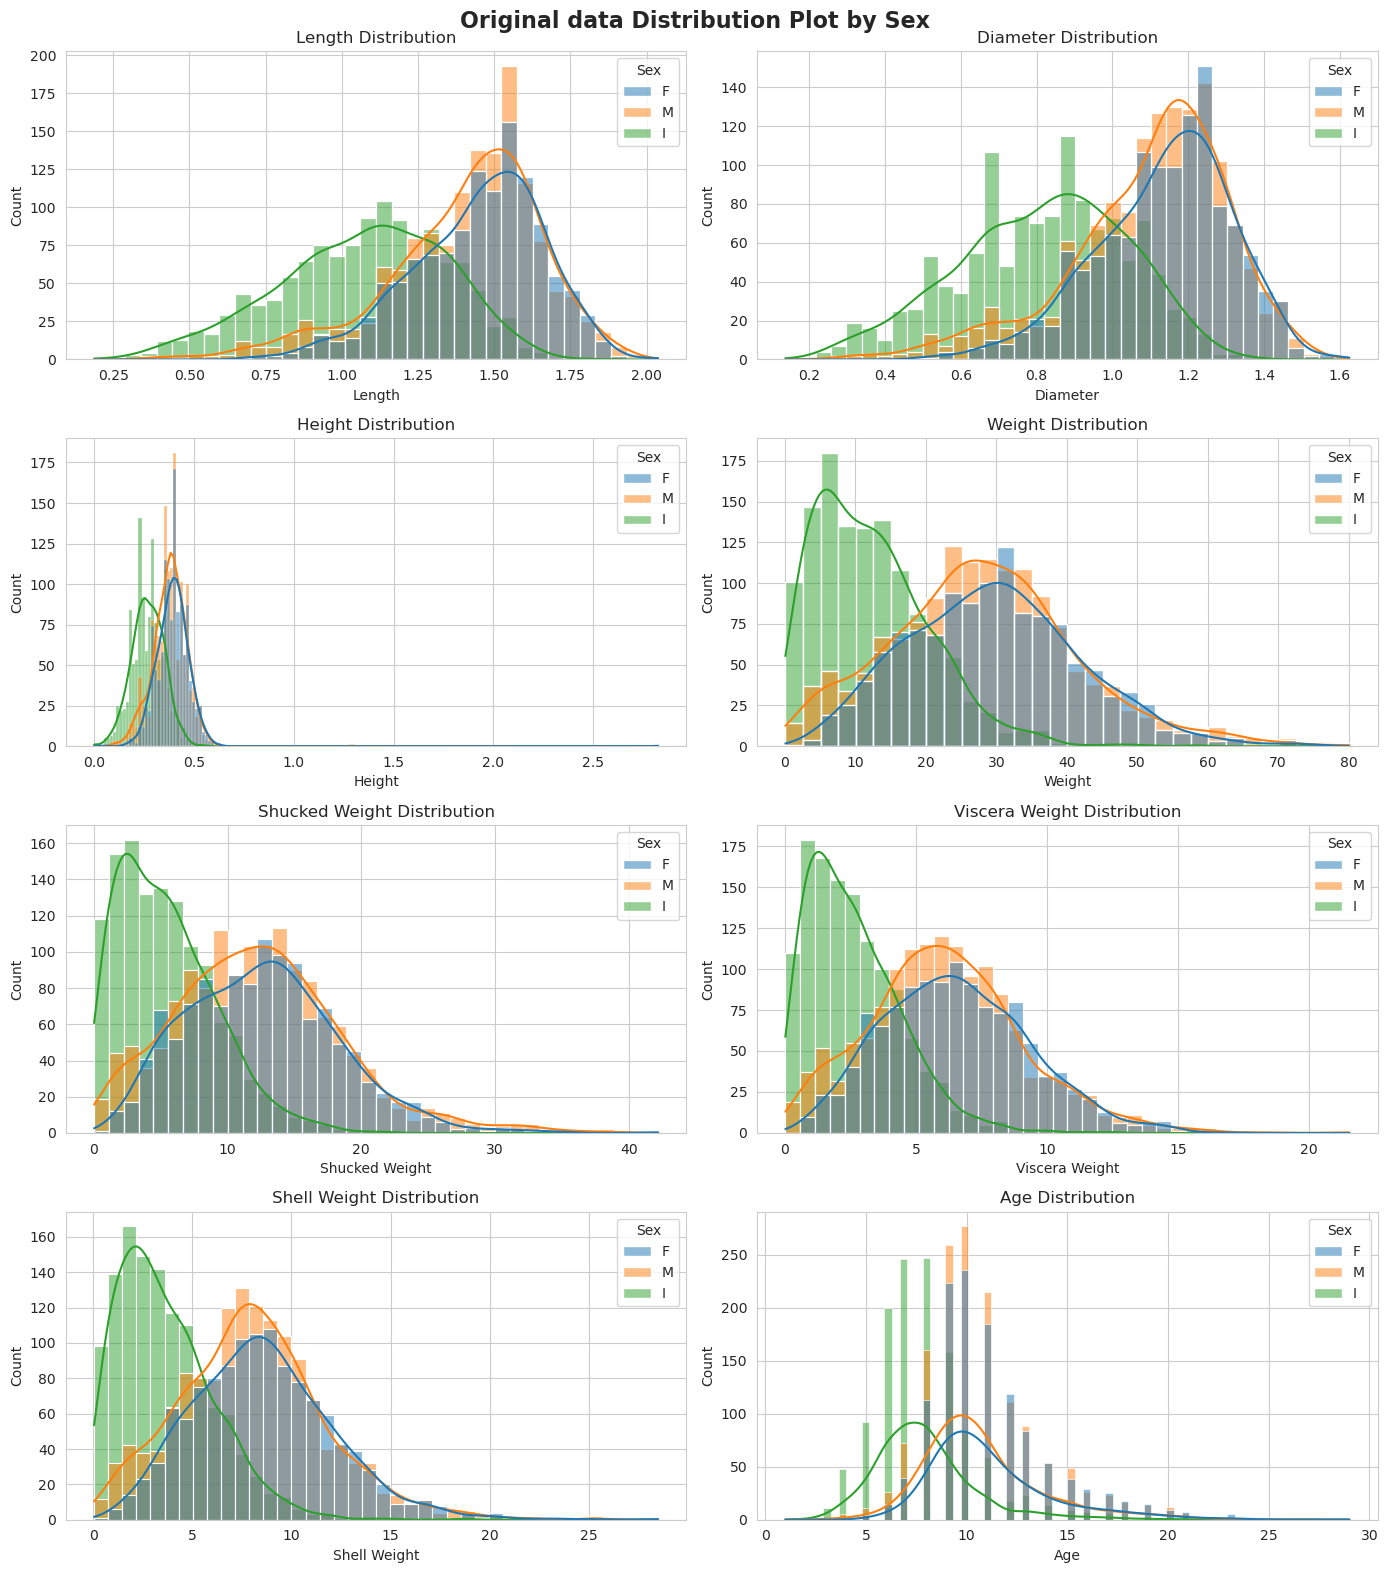

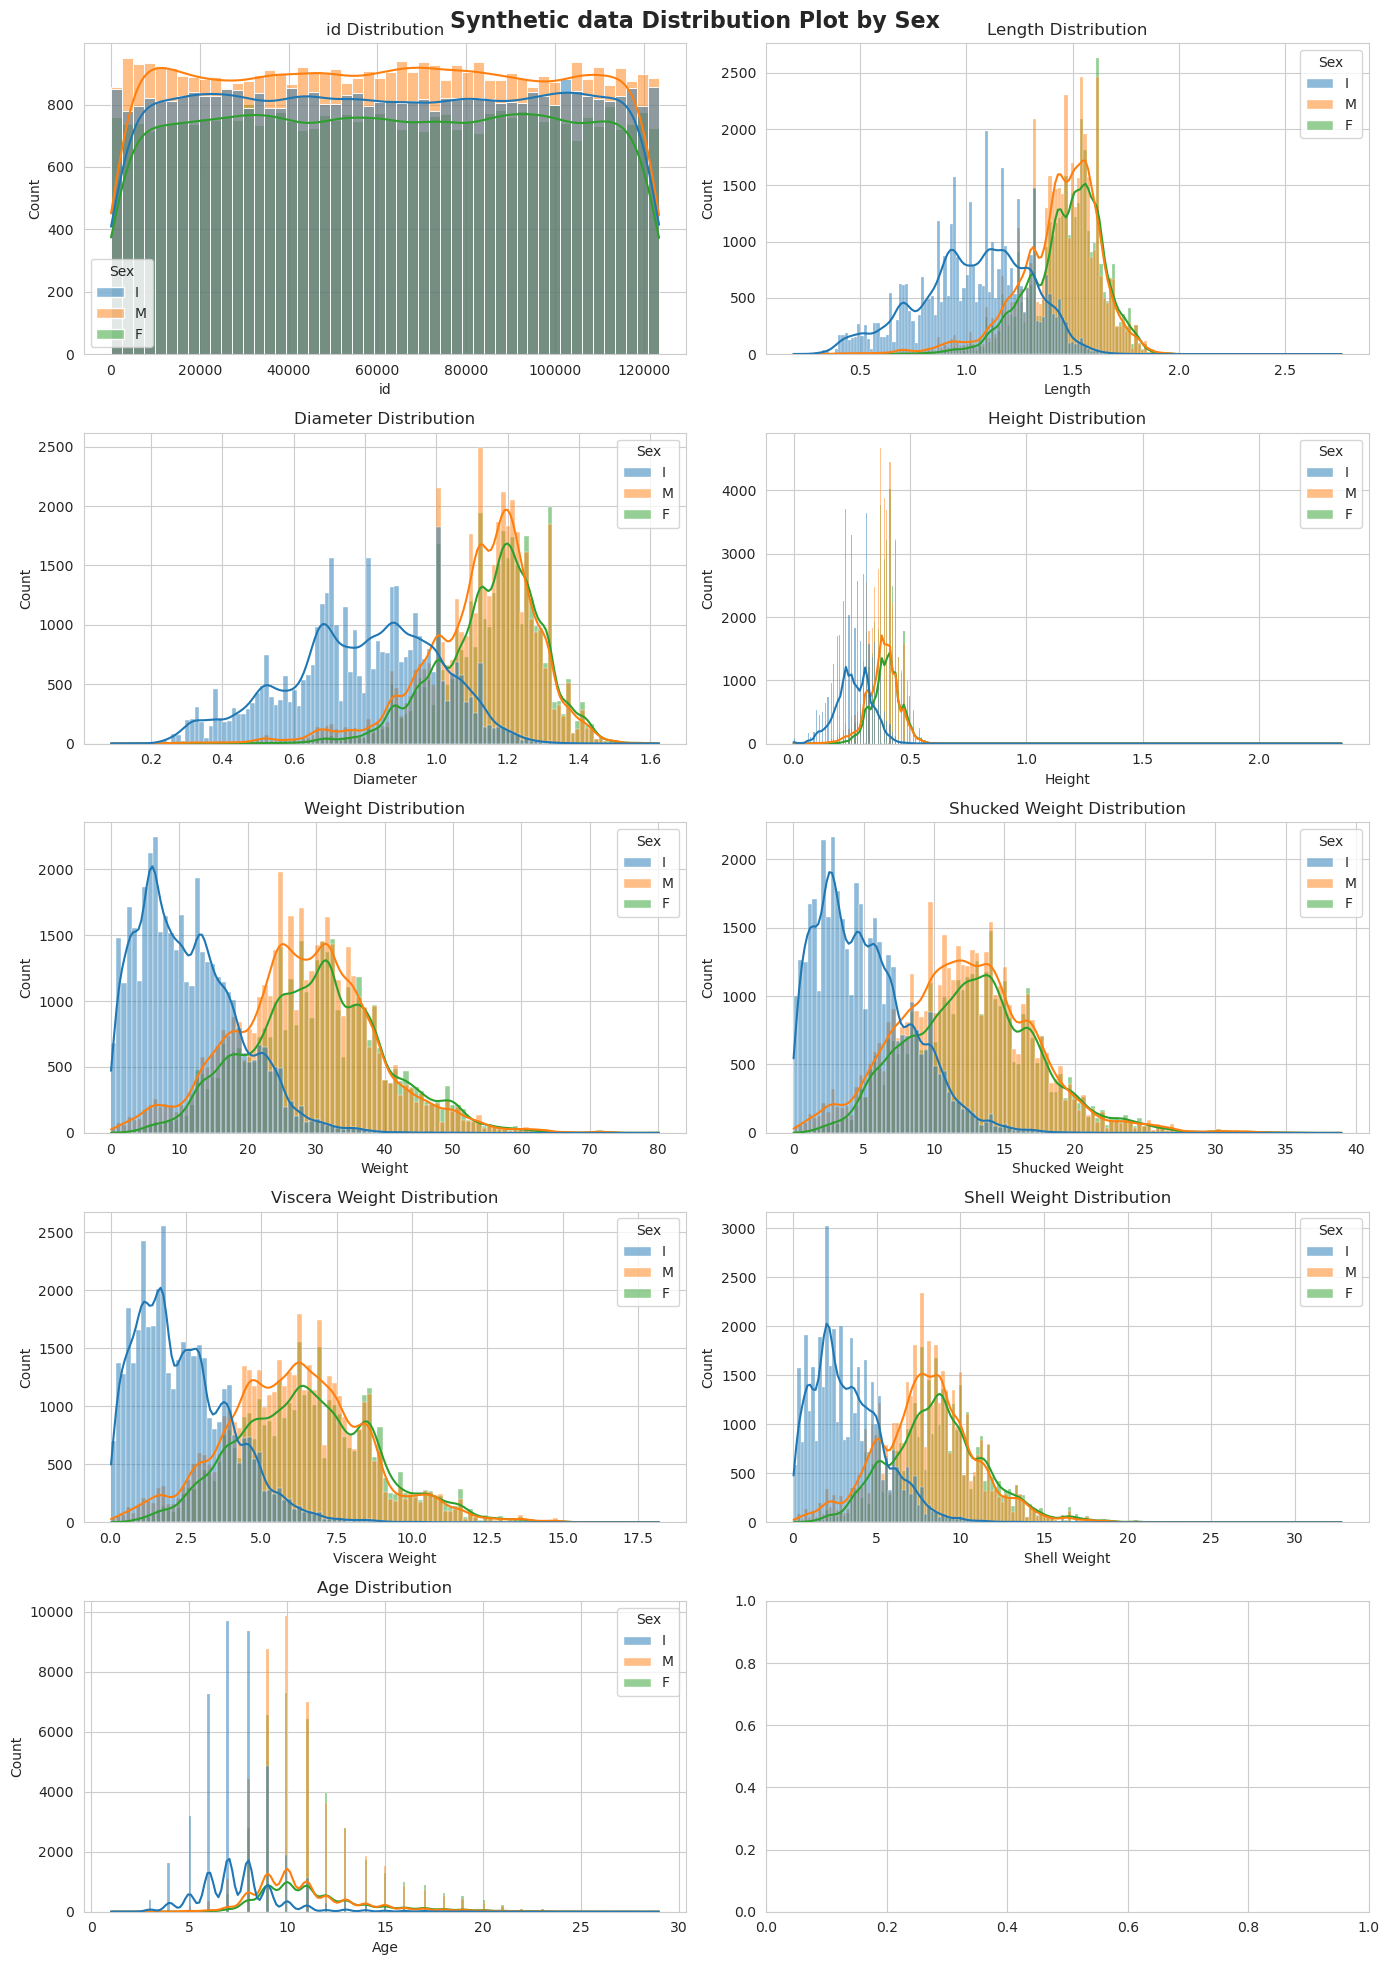

In [15]:
def plot_distribution(df, hue, title='', drop_cols=[]):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distribution(train, hue='Sex', title='Train data')
plot_distribution(test, hue='Sex', title='Test data')
plot_distribution(original, hue='Sex', title='Original data')
plot_distribution(synthetic, hue='Sex', title= 'Synthetic data')

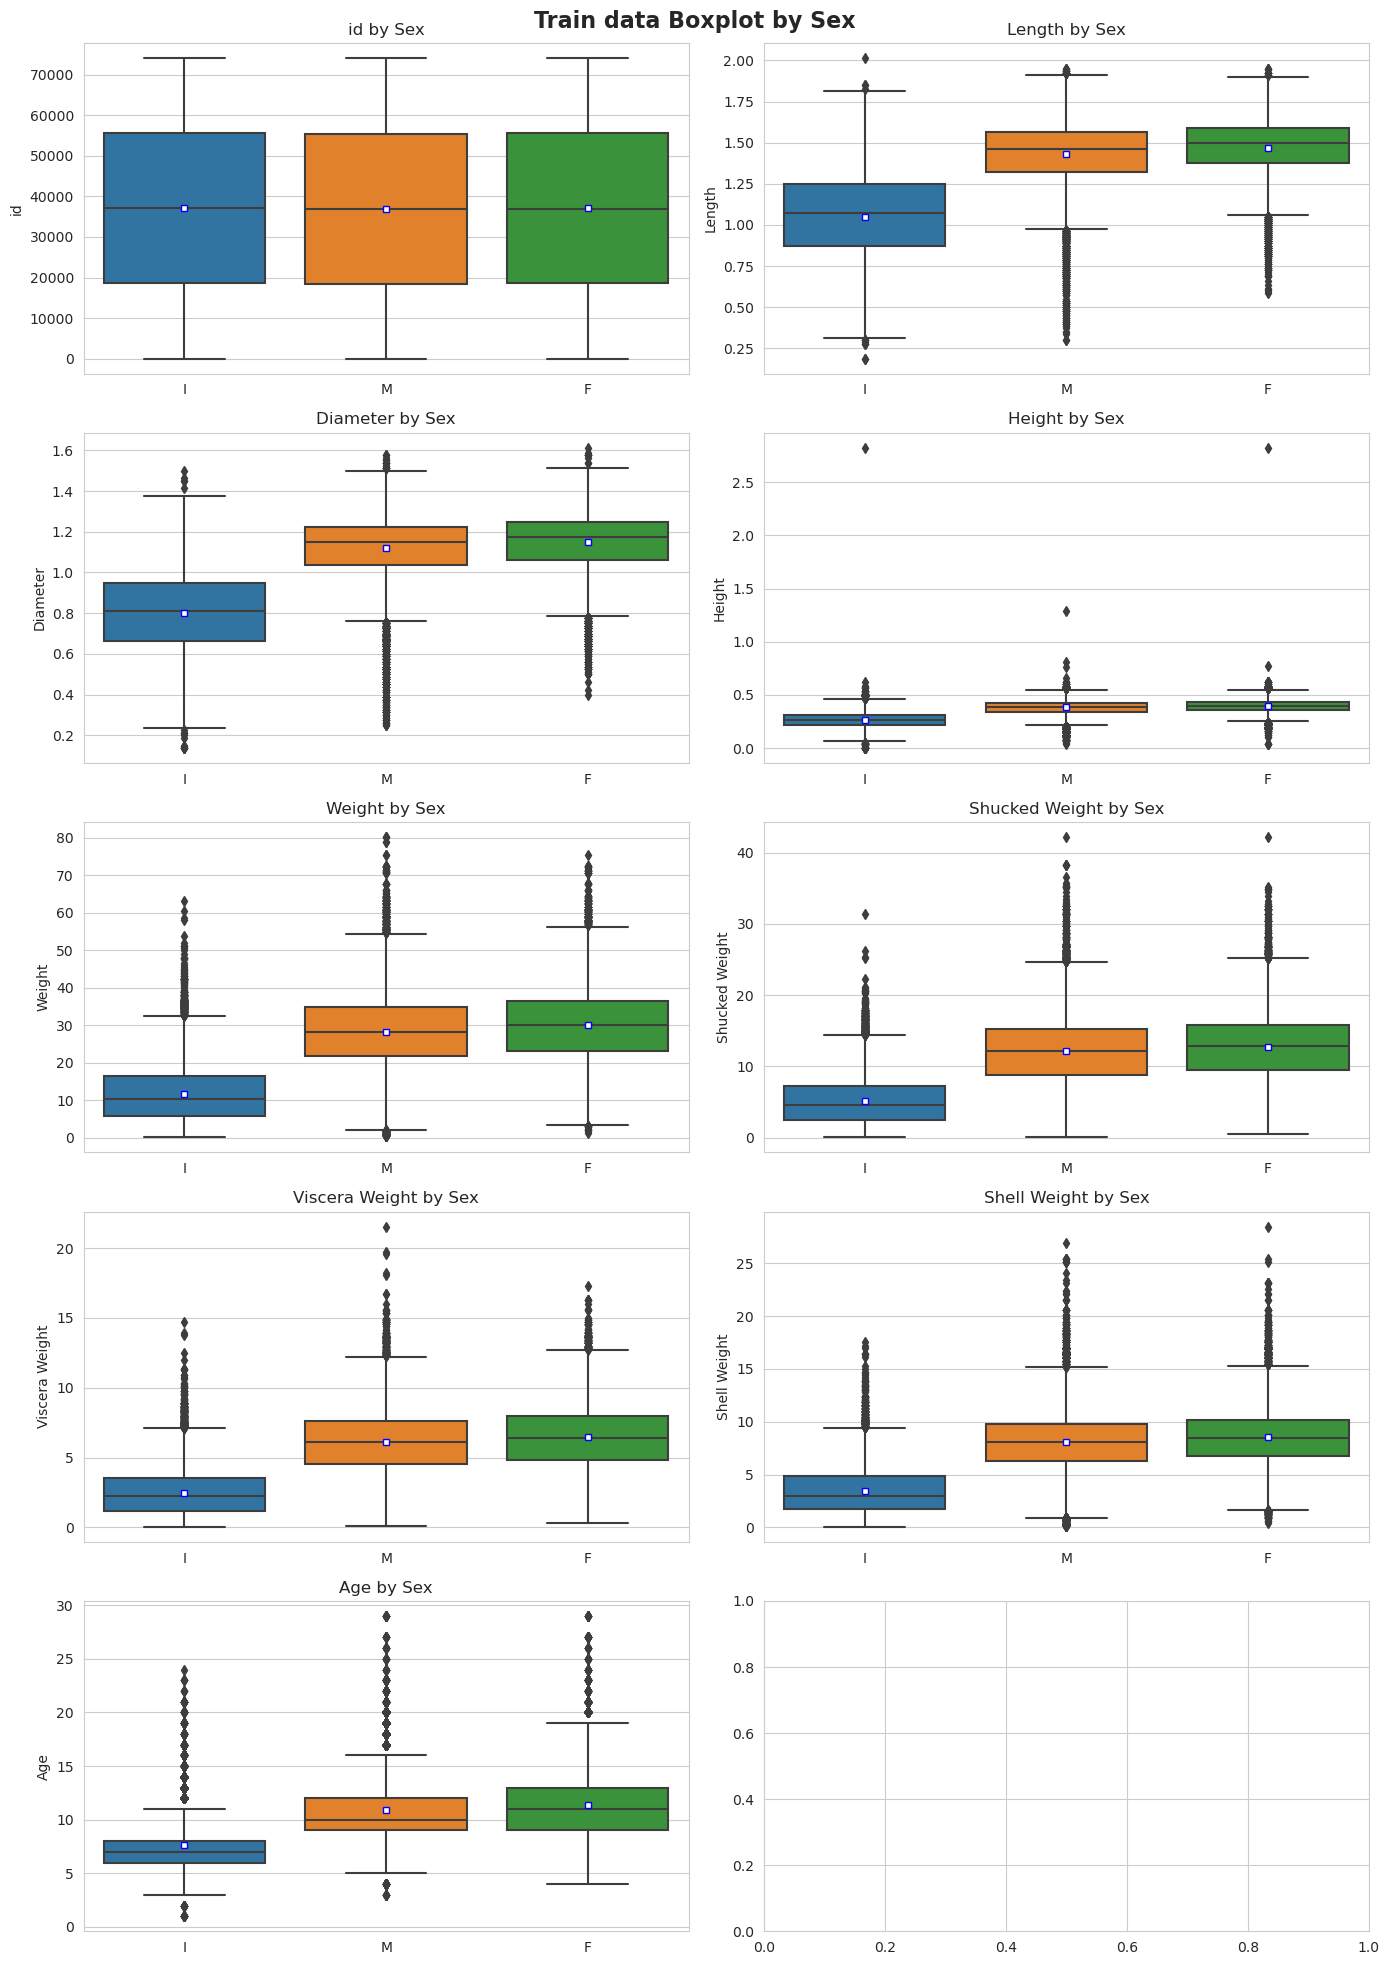

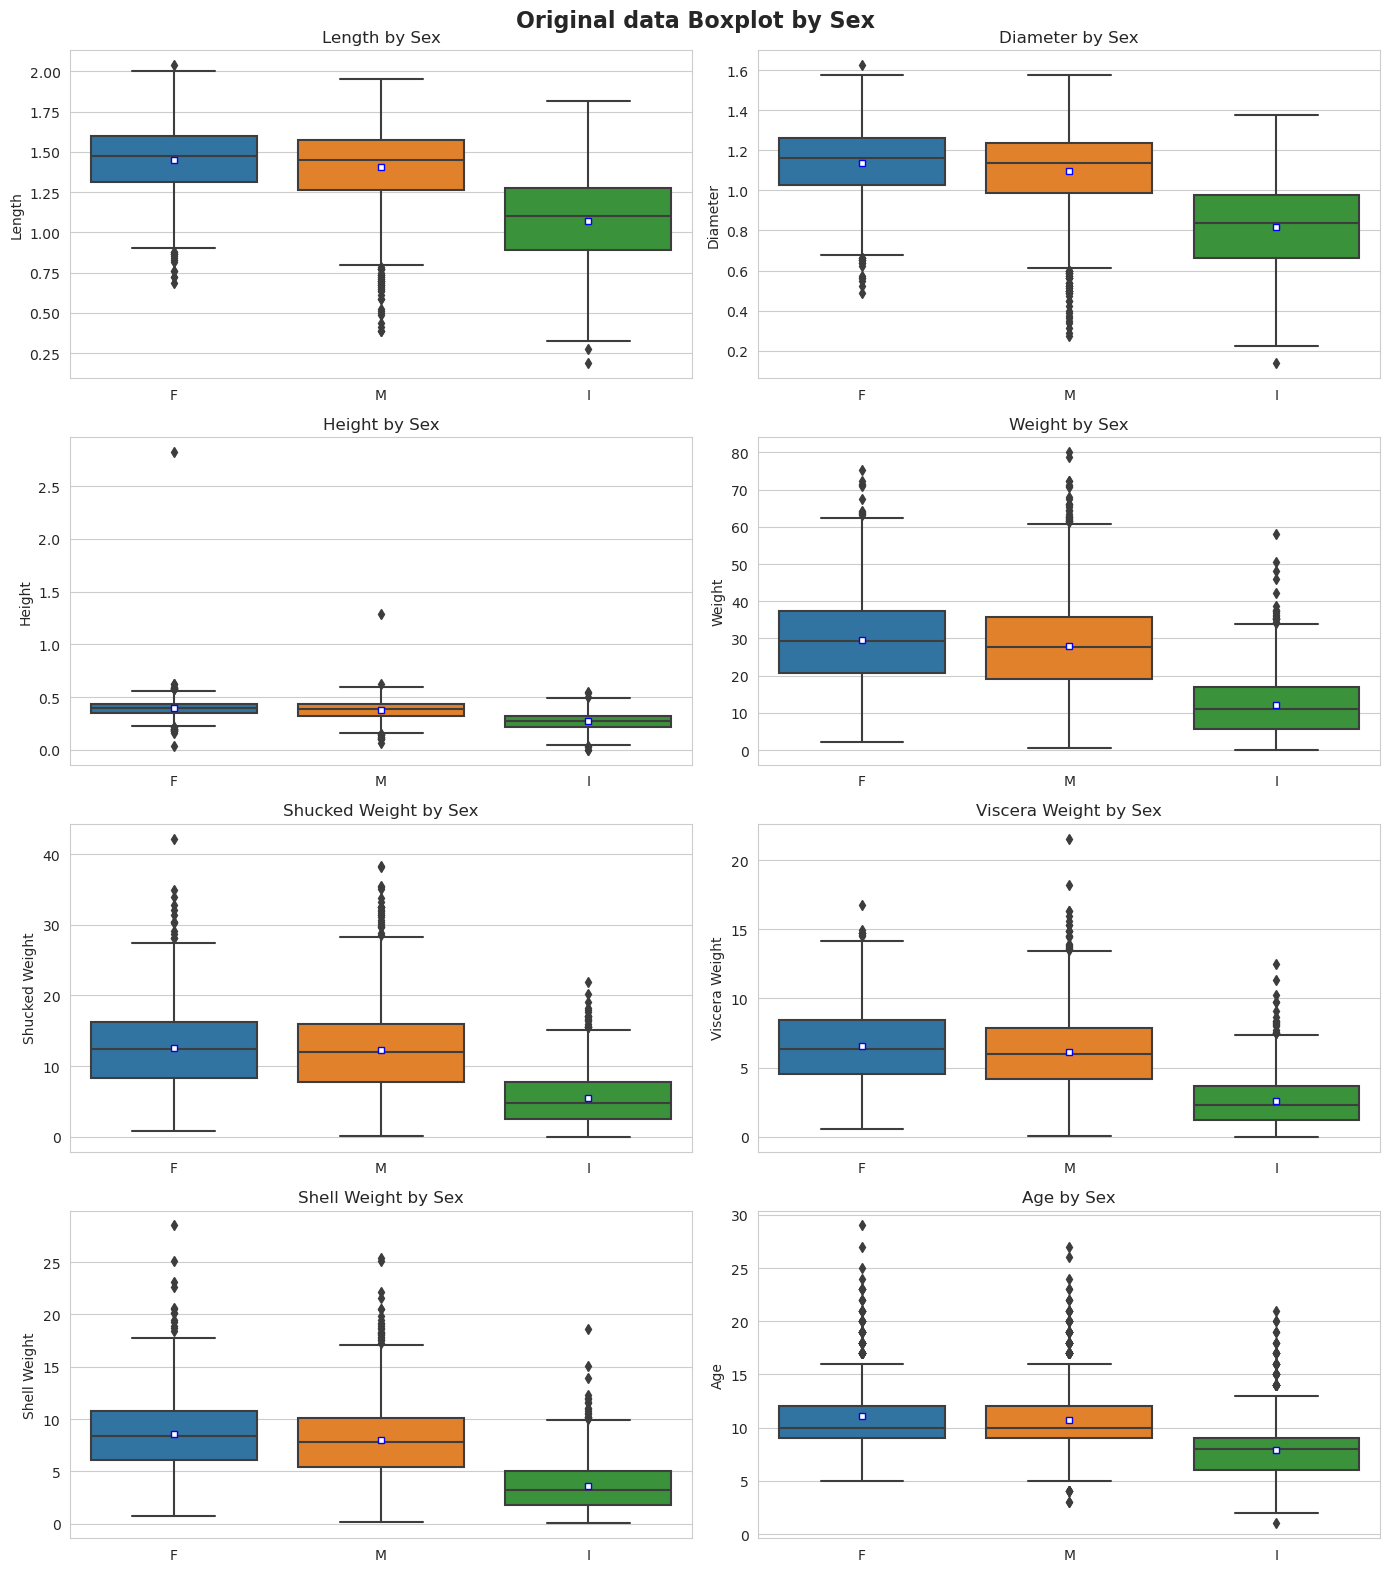

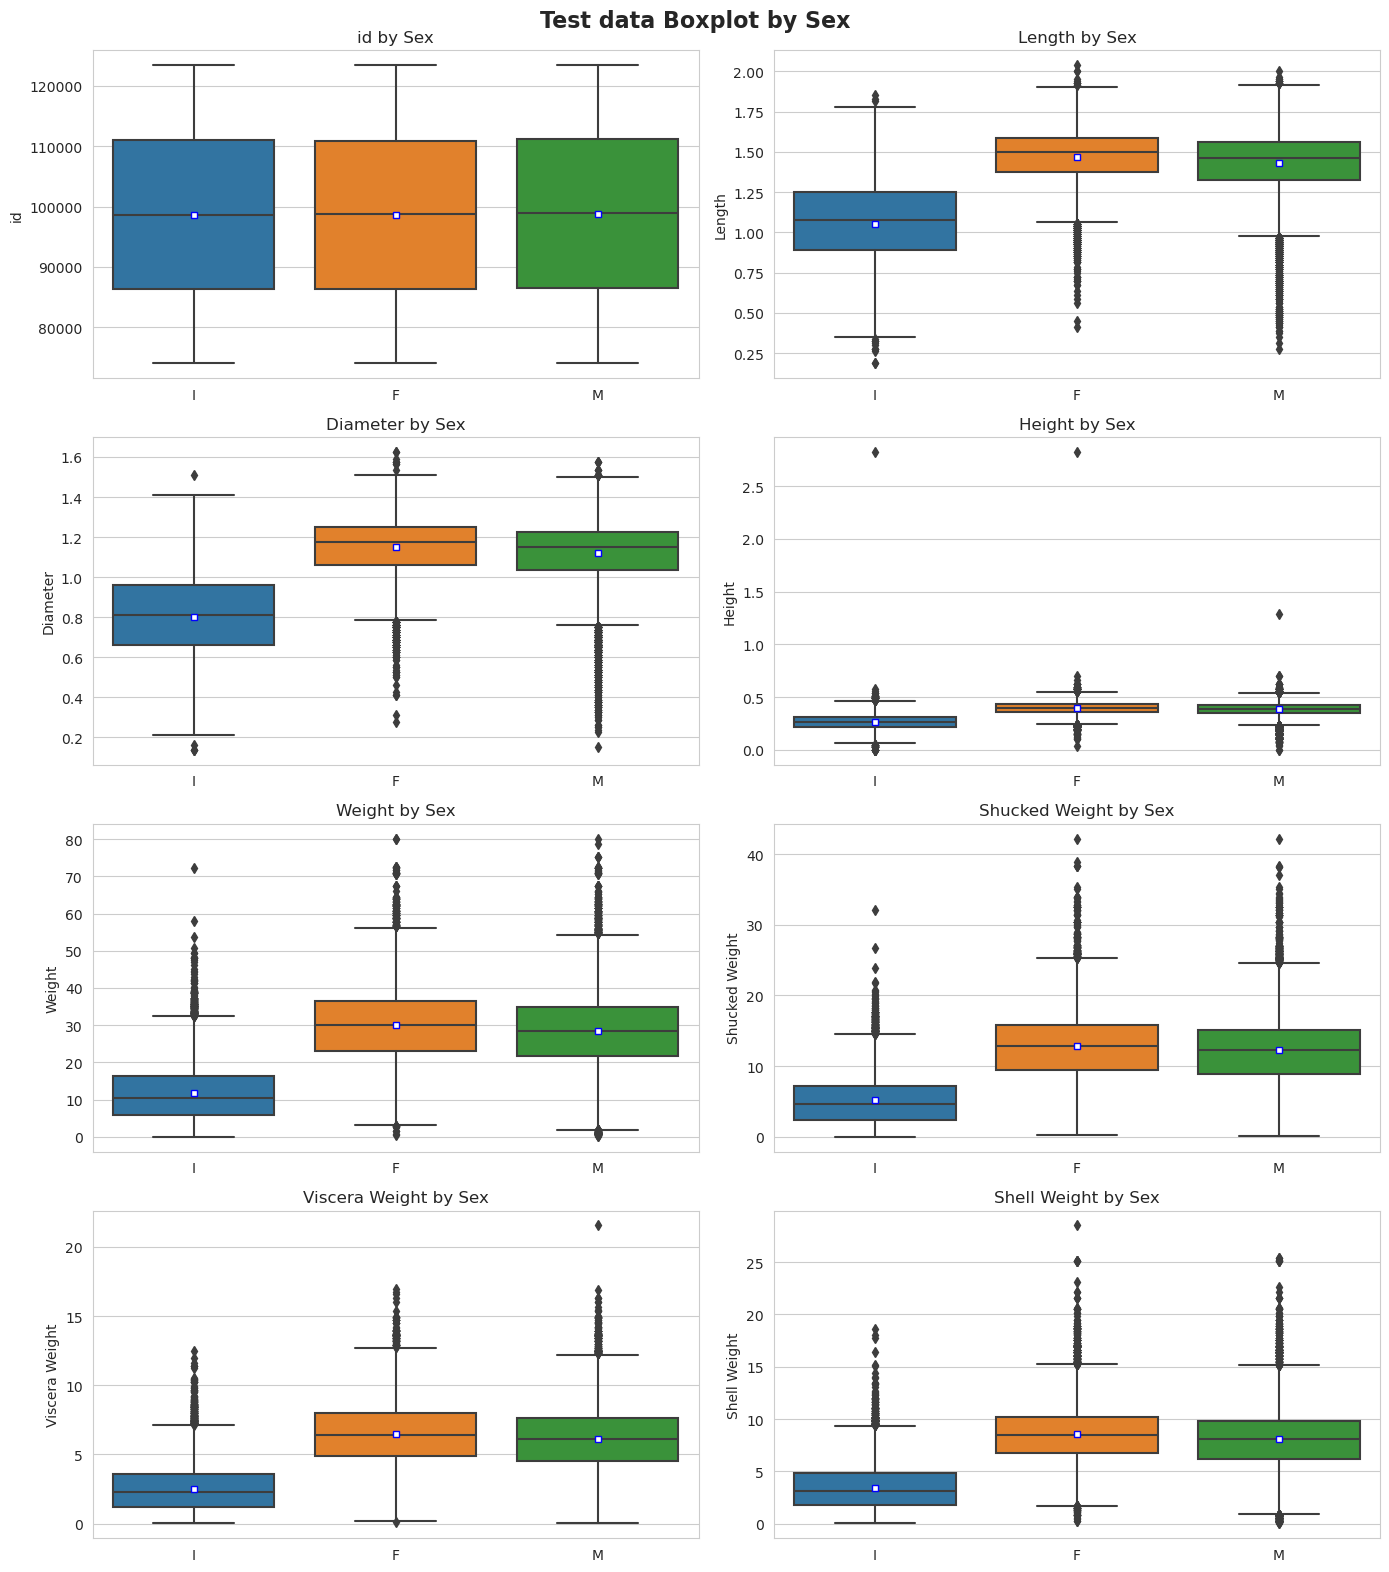

In [16]:
def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(train, hue='Sex', title='Train data', n_cols=2)
plot_boxplot(original, hue='Sex', title='Original data', n_cols=2)
plot_boxplot(test, hue='Sex', title='Test data', n_cols=2)

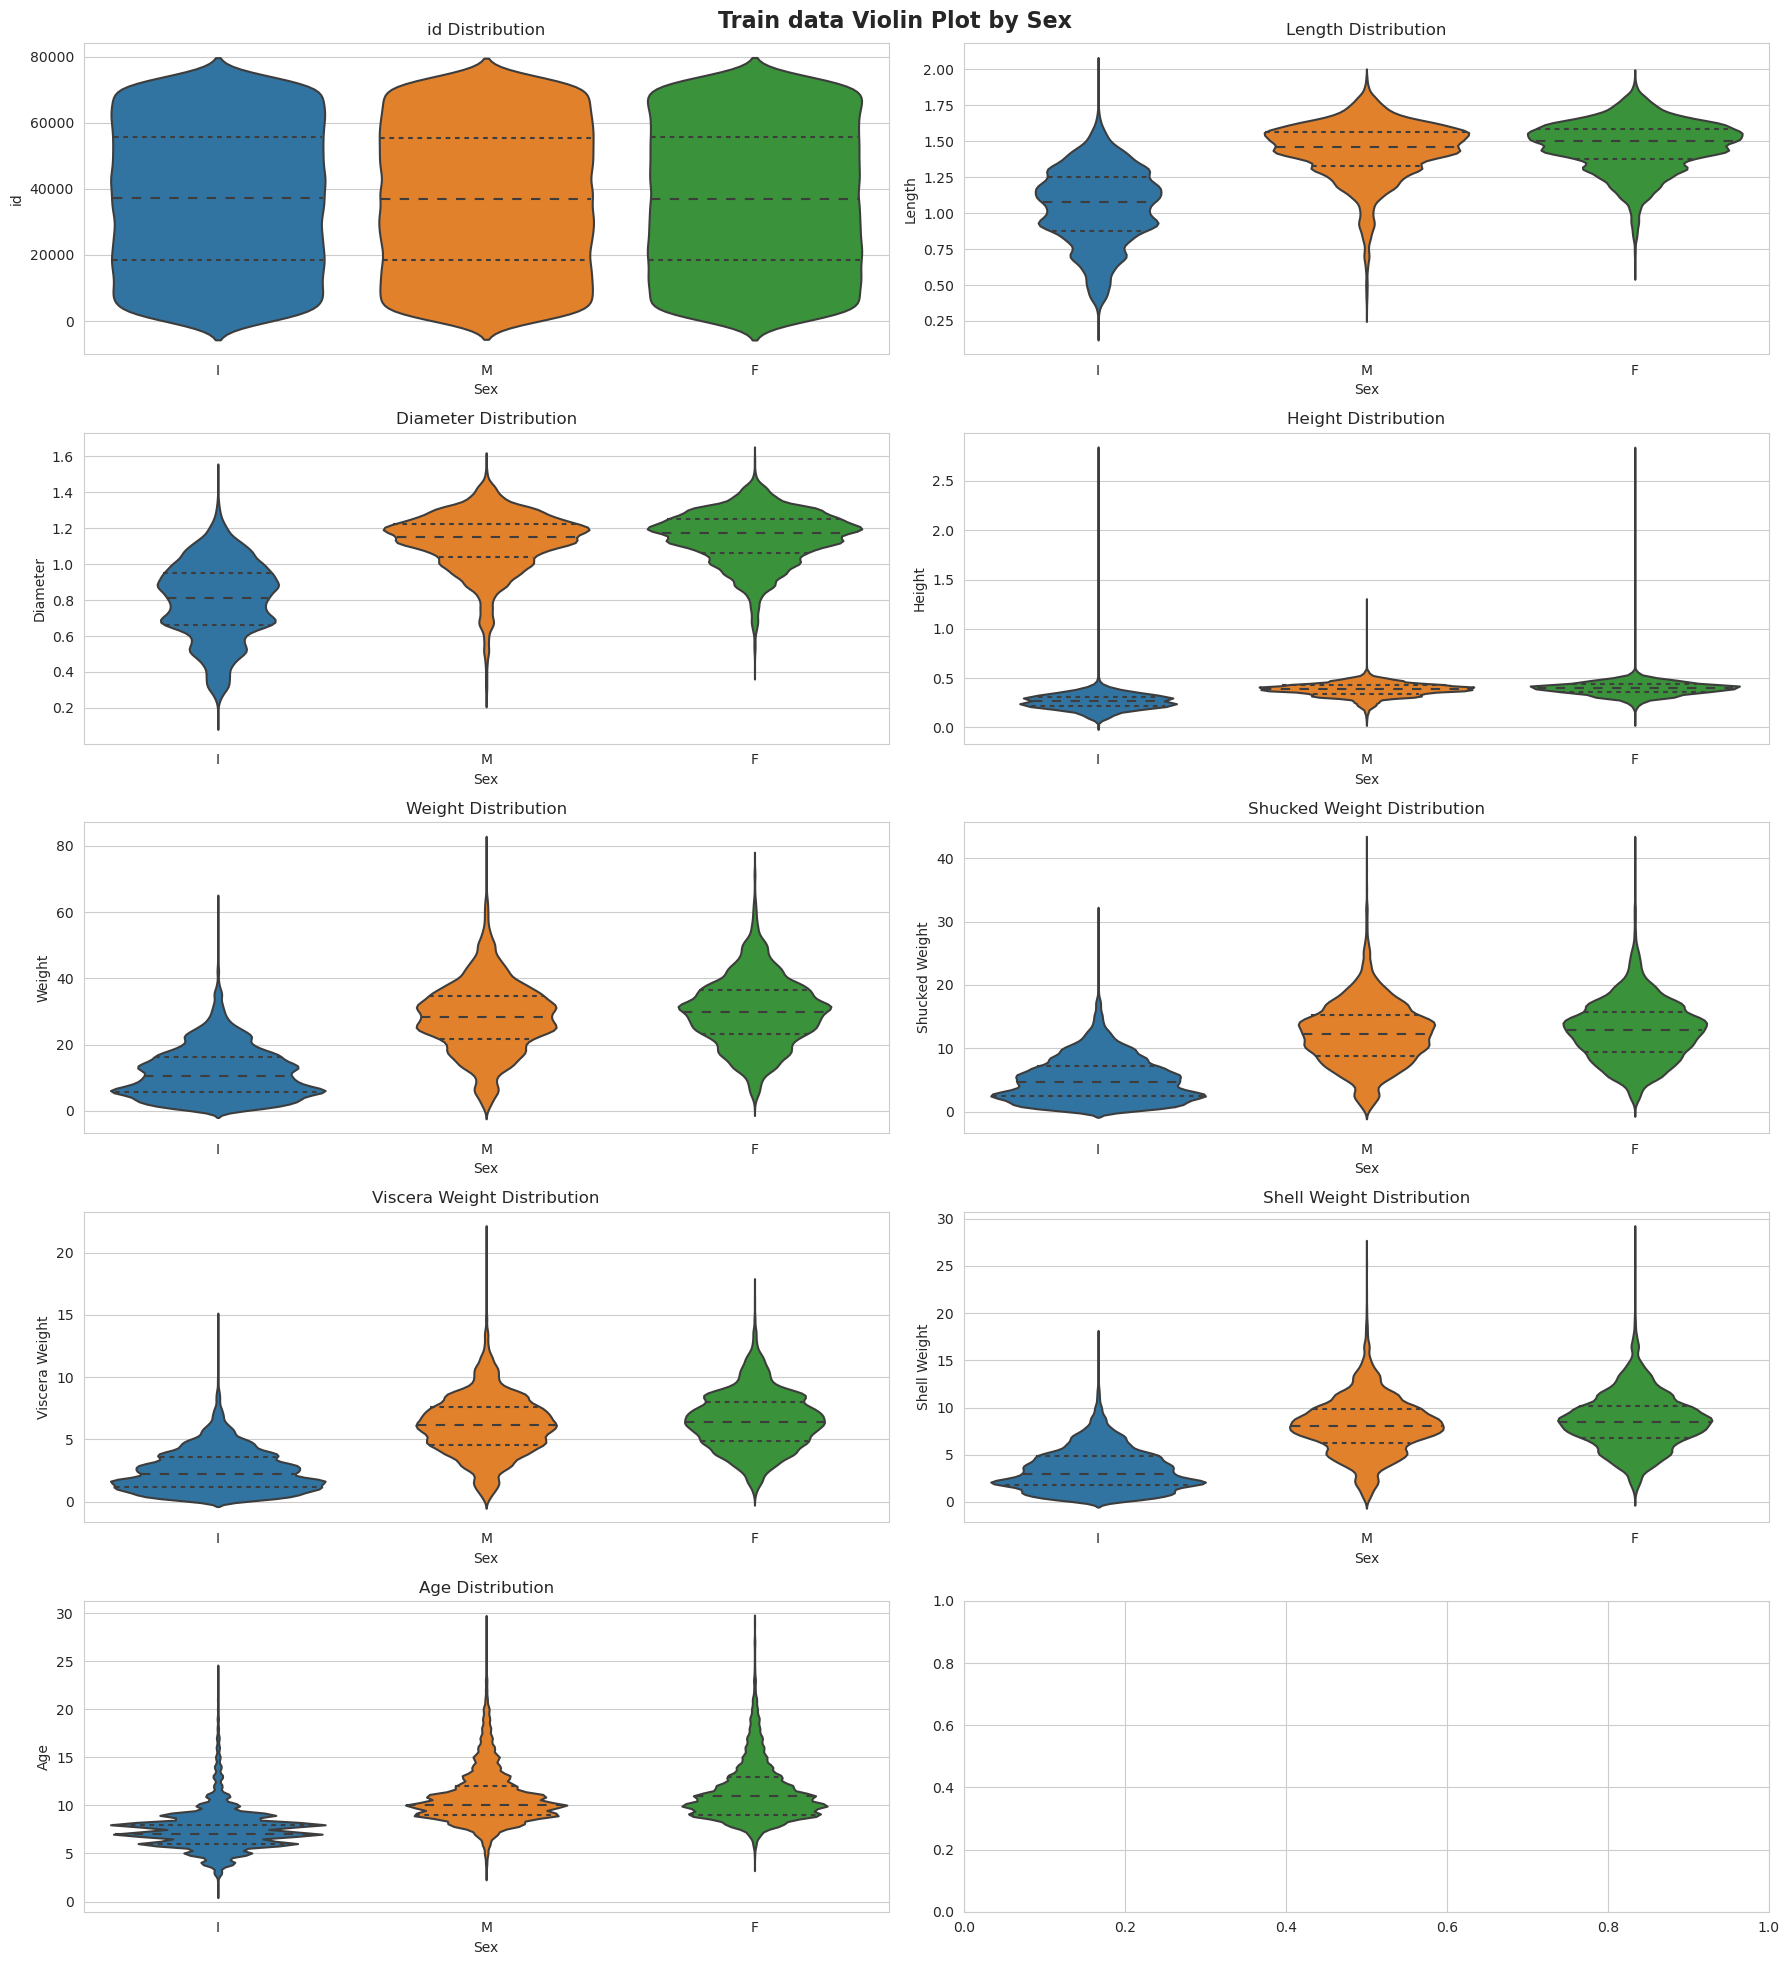

In [17]:
def plot_violinplot(df, hue, title='', drop_cols=[], n_cols=2):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.violinplot(data=df, x=hue, y=var_name, ax=ax, inner='quartile')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Violin Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_violinplot(train, hue='Sex', title='Train data', n_cols=2)

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">2. Bivariate Statistics</p> 

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Recall: There are three types of bivariate analysis.</b><br>       
<ul> 
<li> <b>Numerical - Numerical: Pearson's Correlation</b> </li> <br>
The correlation represents the strength of a linear relationship between two numerical variables. If there is no correlation between the two variables, there is no tendency to change along with the values of the second quantity.  <br>  <br>
<li> <b>Categorical - Numerical: one-way ANOVA(3 + groups) or t-test (exactly 2 groups)</b>       </li> <br>
The ANOVA test is used to determine whether there is a significant difference among the averages of more than two groups that are statistically different from each other. <br><br>
<li> <b>Categorical - Categorical: Chi-square Test</b>       </li> <br>
It is calculated based on the difference between expected frequencies and the observed frequencies in one or more categories of the frequency table.
</ul>
</p> 

In [18]:
# this just an intermediate function that will be used in bivstats for one-way ANOVA
def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)

# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA
def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
    # Create an empty DataFrame to store output
    output_df = pd.DataFrame(columns=['Stat', '+/-', 'Effect size', 'p-value'])
    
    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):   # Only calculate r, 
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                    
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
                    
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]

    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])
 
pd.options.display.float_format = '{:.5f}'.format
bivstats(train, target)

Stat     +/-  Effect size  p-value
Sex               F          13657.03600  0.00000
Shell Weight      r 1.00000      0.66300  0.00000
Height            r 1.00000      0.63800  0.00000
Diameter          r 1.00000      0.62100  0.00000
Length            r 1.00000      0.61300  0.00000
Weight            r 1.00000      0.60100  0.00000
Viscera Weight    r 1.00000      0.57700  0.00000
Shucked Weight    r 1.00000      0.50300  0.00000
id                r 1.00000      0.00000  0.98067

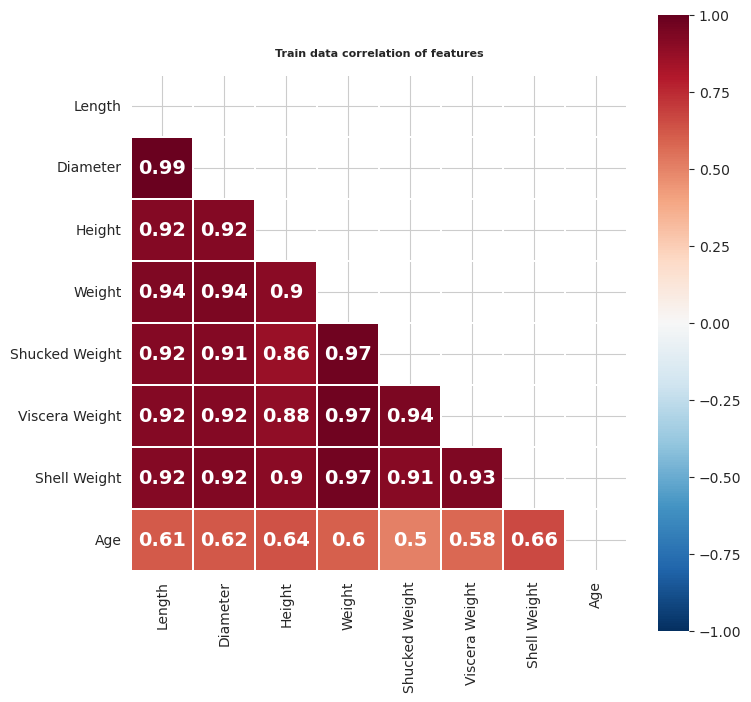

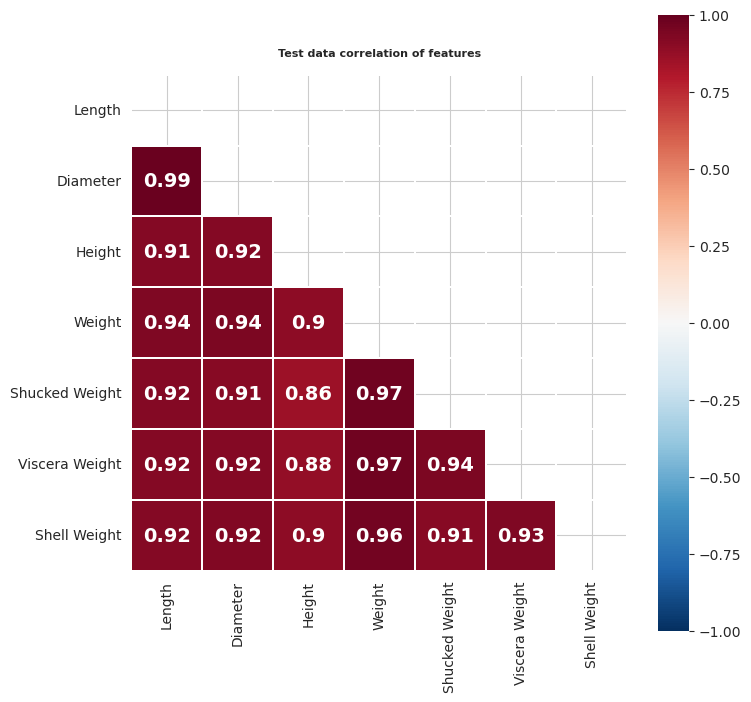

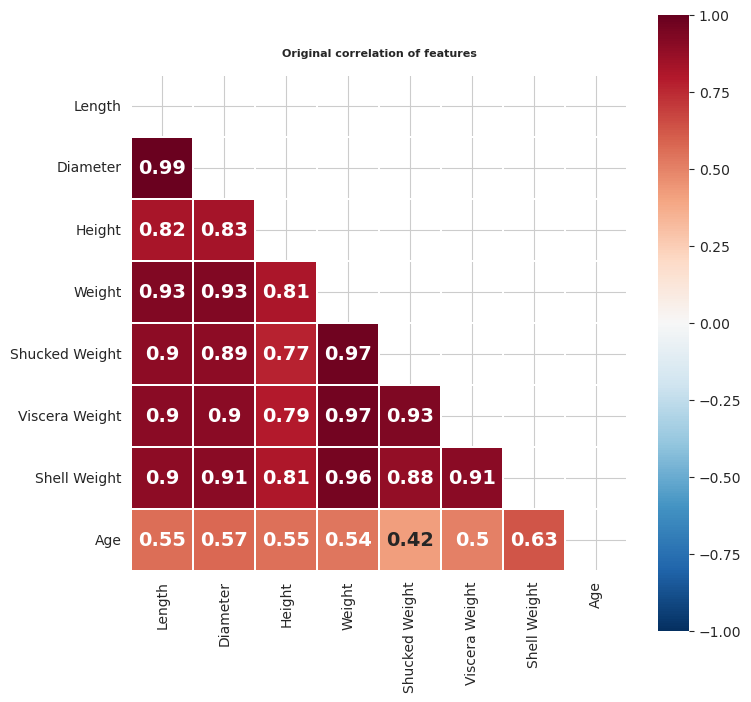

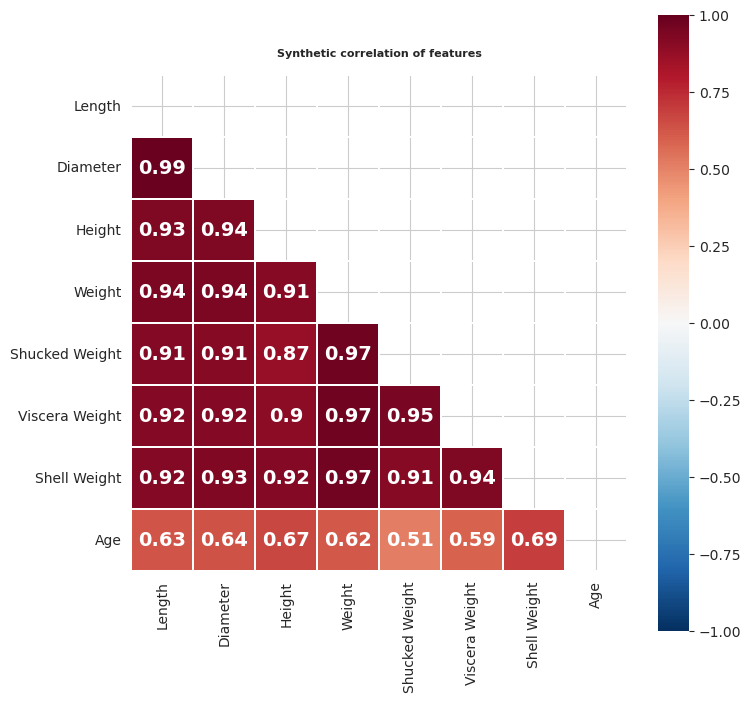

In [19]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(8, 8))

    # Set the title and font properties
    plt.title(f'{title} correlation of features', fontweight='bold', y=1.02, size=8)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train[numeric_cols + [target]], title='Train data')
plot_heatmap(test[numeric_cols], title='Test data')
plot_heatmap(original[numeric_cols + [target]], title='Original')
plot_heatmap(synthetic[numeric_cols + [target]], title='Synthetic')

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
Since the features in our datasets are strongly correlated to each others, applying PCA could be a good idea. <br>
        Let's visualize some graphics to gain more insights.
</b>
</p> 



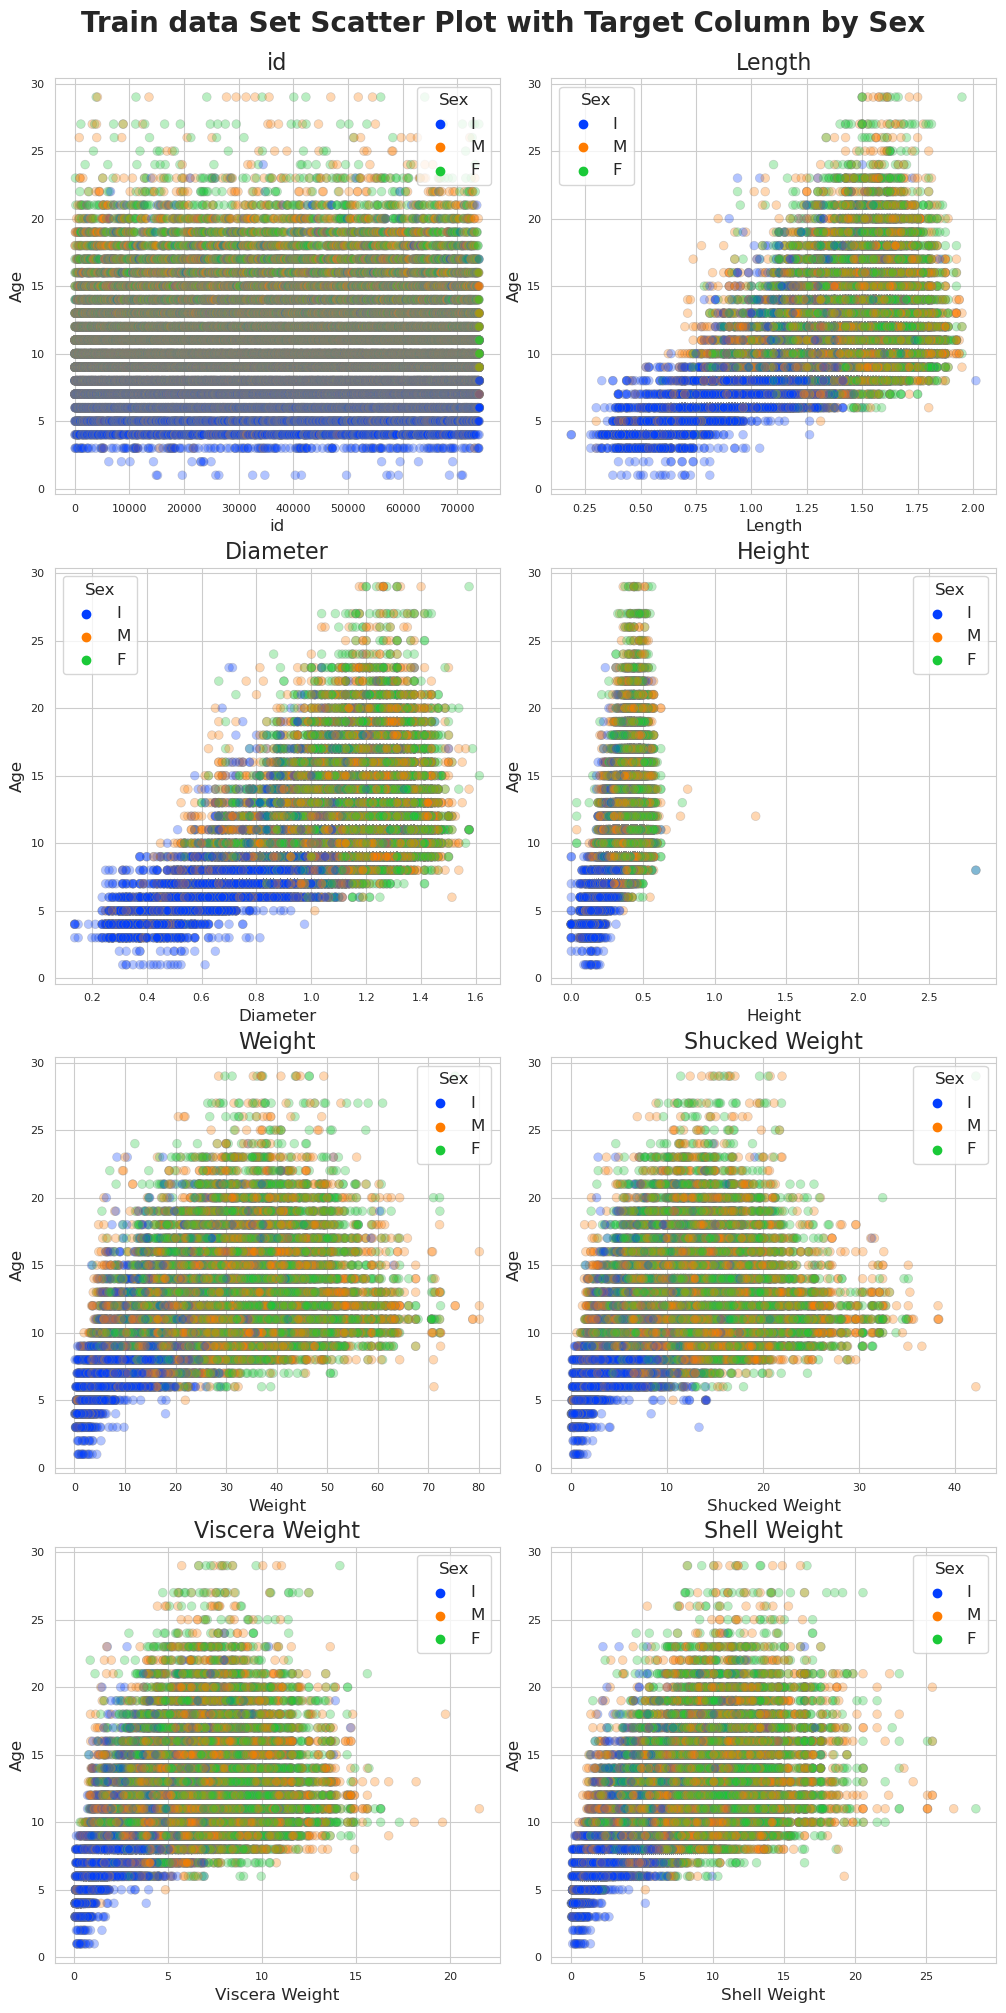

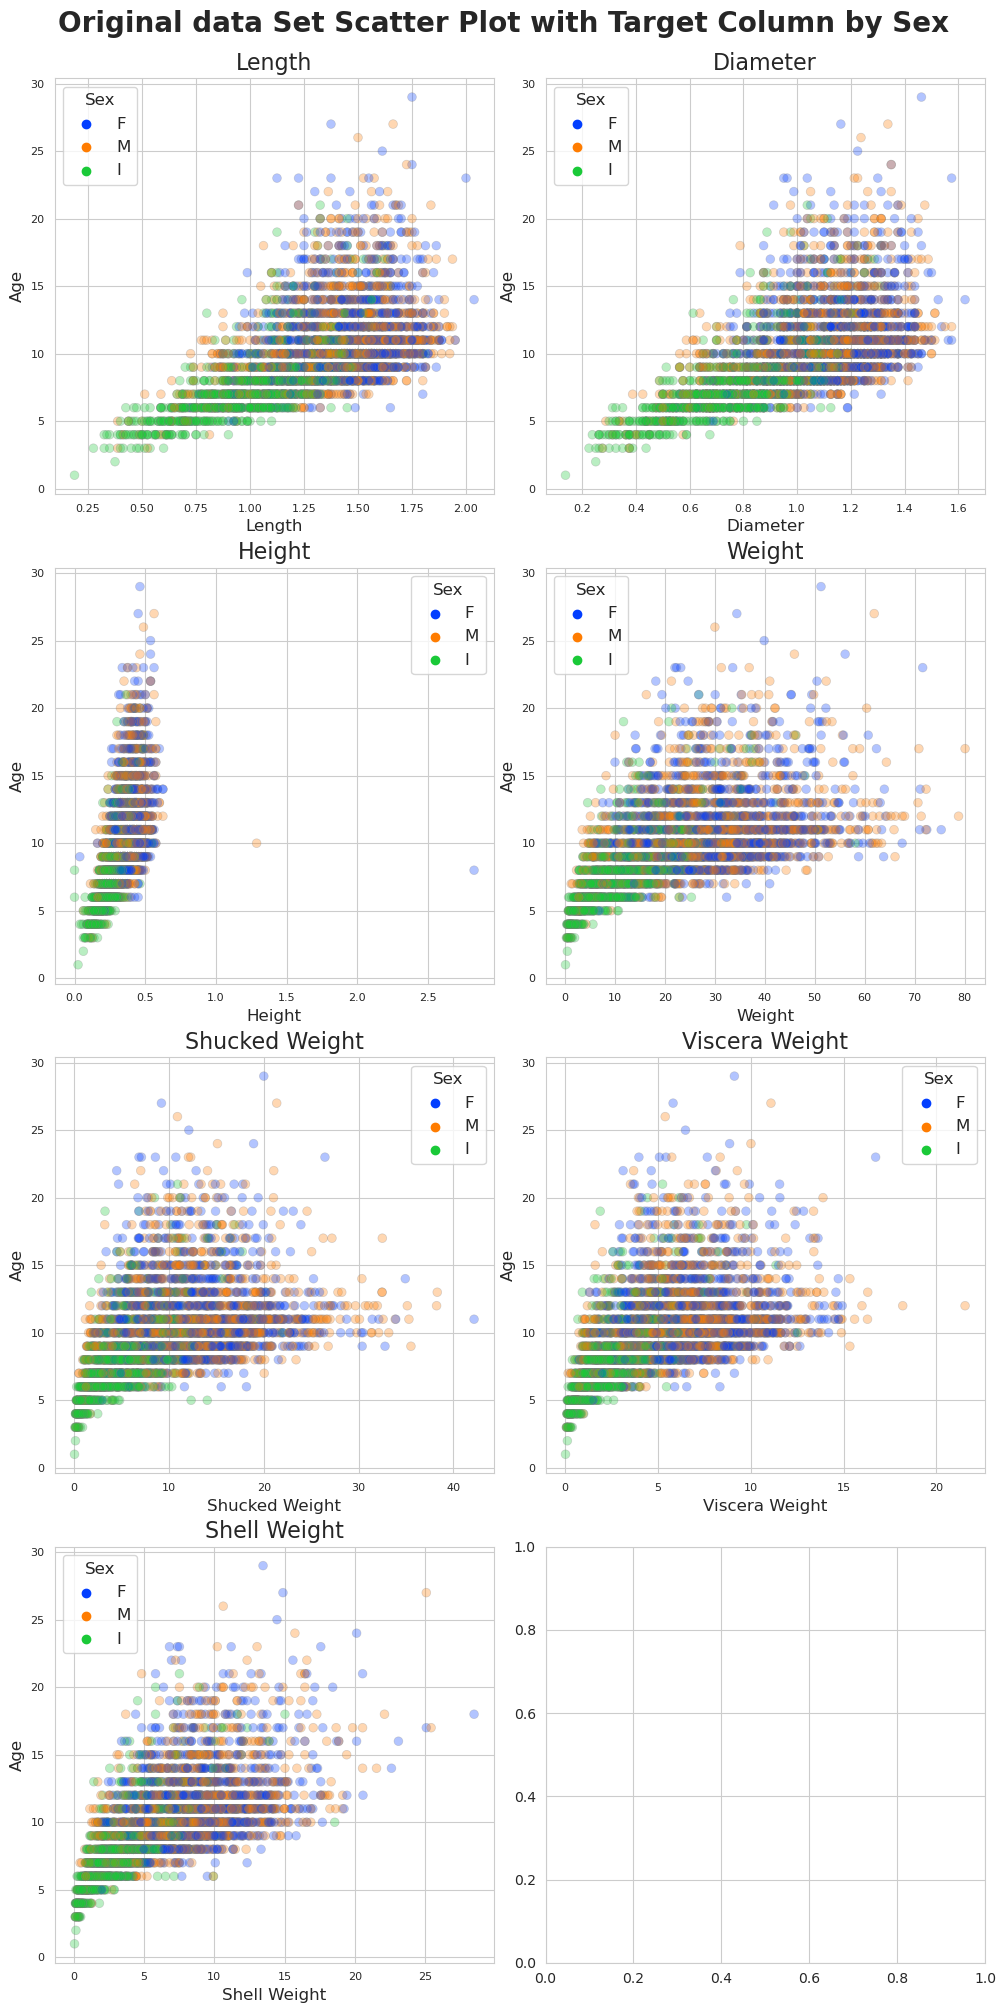

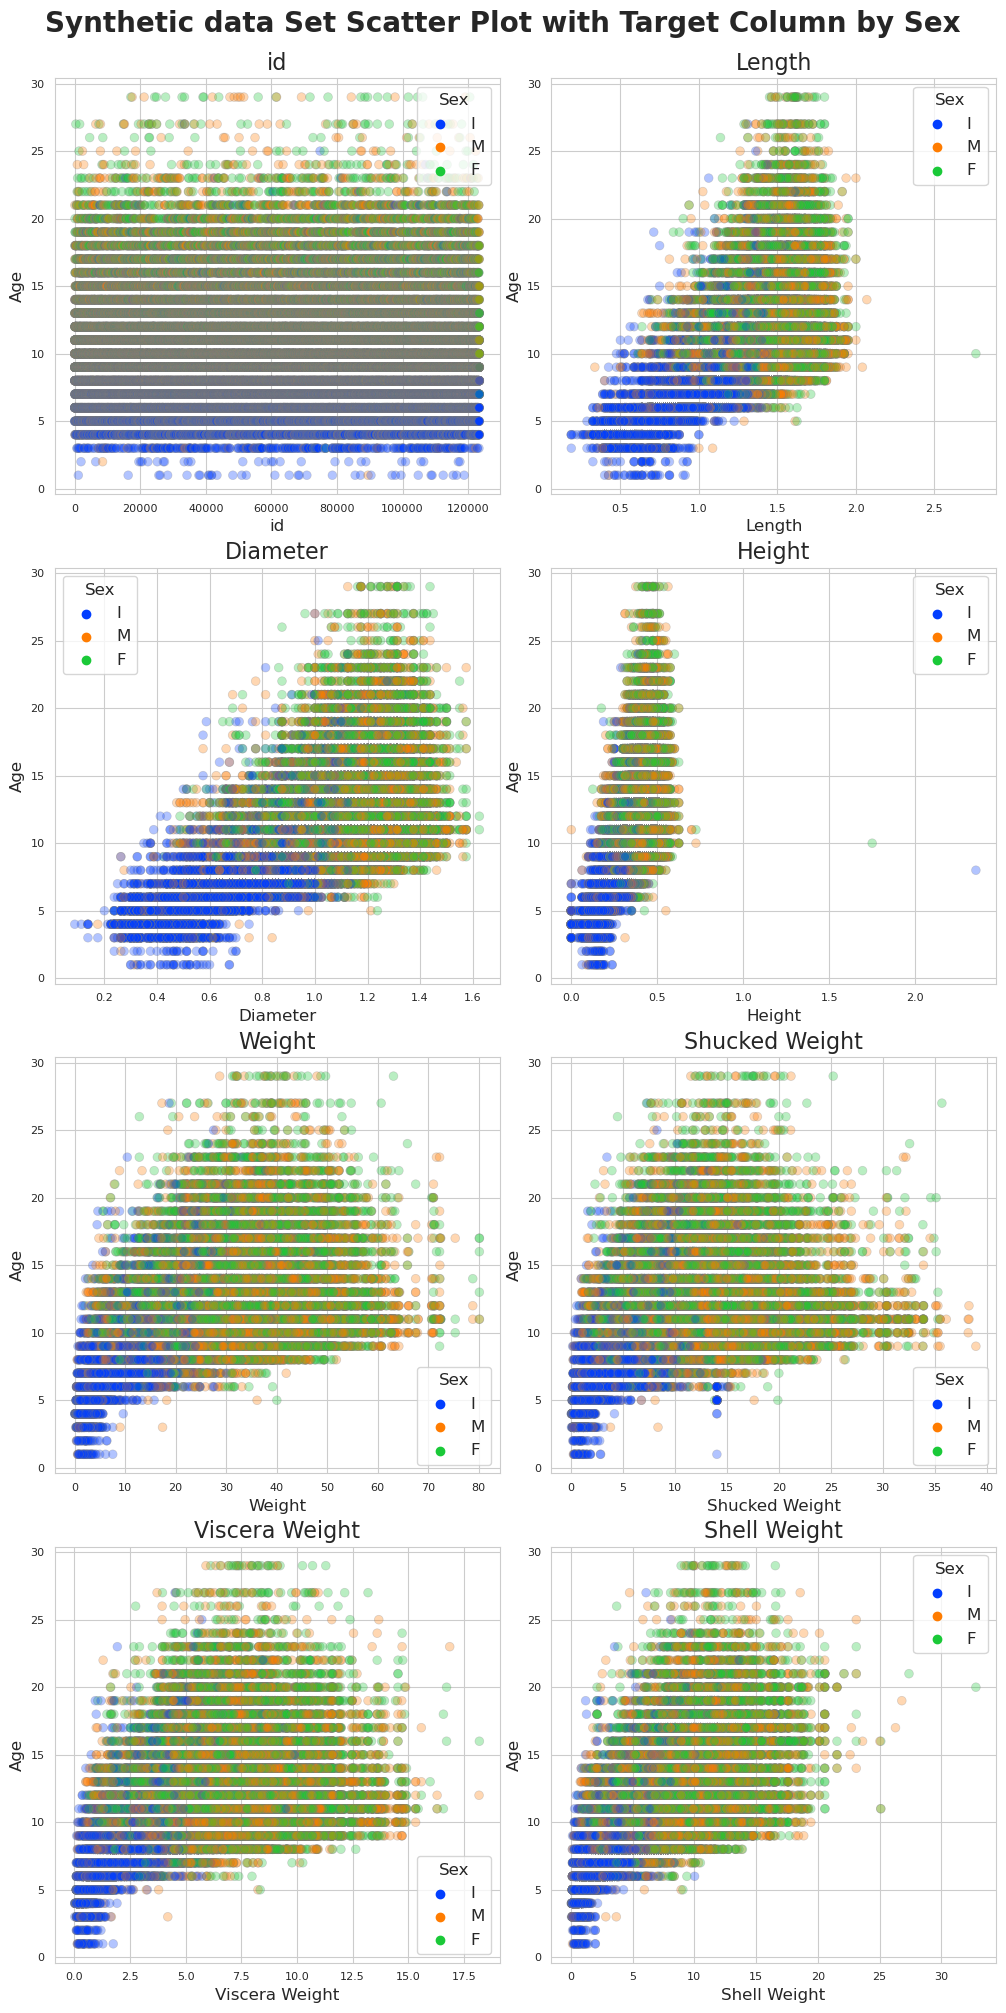

In [20]:
def plot_scatter_with_fixed_col(df, fixed_col, hue=False, drop_cols=[], size=5, title=''):
    sns.set_style('whitegrid')
    
    if hue:
        cols = df.columns.drop([hue, fixed_col] + drop_cols)
    else:
        cols = df.columns.drop([fixed_col] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size, size/n_cols*n_rows), sharex=False, sharey=False)
    fig.suptitle(f'{title} Set Scatter Plot with Target Column by {hue}', fontsize=20, fontweight='bold', y=1)

    for i, col in enumerate(cols):
        n_row = i // n_cols
        n_col = i % n_cols
        ax = axes[n_row, n_col]

        ax.set_xlabel(f'{col}', fontsize=12)
        ax.set_ylabel(f'{fixed_col}', fontsize=12)

        # Plot the scatterplot
        if hue:
            sns.scatterplot(data=df, x=col, y=fixed_col, hue=hue, ax=ax,
                            s=40, edgecolor='gray', alpha=0.3, palette='bright')
            ax.legend(title=hue, title_fontsize=12, fontsize=12) # loc='upper right'
        else:
            sns.scatterplot(data=df, x=col, y=fixed_col, ax=ax,
                            s=40, edgecolor='gray', alpha=0.3)

        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_title(f'{col}', fontsize=16)
    
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.show()
    
plot_scatter_with_fixed_col(train, fixed_col=target, hue='Sex', size=10, title='Train data')
plot_scatter_with_fixed_col(original, fixed_col=target, hue='Sex', size=10, title='Original data')
plot_scatter_with_fixed_col(synthetic, fixed_col=target, hue='Sex', size=10, title='Synthetic data')

In [21]:
# sns.pairplot(data=train, vars=['Age', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'], hue='Sex')
# plt.show()

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Feature Engineering</p> 

In [22]:
train["Data Type"] = 0
test["Data Type"] = 1
original["Data Type"] = 2
synthetic["Data Type"] = 3

ids = []
for i in range(len(original)):
    ids.append(i + 123419)

original["id"] = ids
synthetic["id"] += 127312

# concatenate datasets
df_concat = pd.concat([train, original, synthetic], ignore_index=True)
df_concat = df_concat.drop_duplicates()
df_all = pd.concat([df_concat, test], ignore_index=True)
df_all

id Sex  Length  Diameter  Height   Weight  Shucked Weight  \
0            0   I 1.52500   1.17500 0.37500 28.97319        12.72893   
1            1   I 1.10000   0.82500 0.27500 10.41844         4.52175   
2            2   M 1.38750   1.11250 0.37500 24.77746        11.33980   
3            3   F 1.70000   1.41250 0.50000 50.66056        20.35494   
4            4   I 1.25000   1.01250 0.33750 23.28911        11.97766   
...        ...  ..     ...       ...     ...      ...             ...   
250702  123414   F 1.30000   1.03750 0.32500 16.31514         6.69048   
250703  123415   I 1.03750   0.76250 0.26250 10.27669         4.43670   
250704  123416   F 1.48750   1.16250 0.36250 31.38290        11.39650   
250705  123417   F 1.23750   0.95000 0.28750 15.66310         6.09514   
250706  123418   M 1.66250   1.30000 0.43750 36.61338        14.91184   

        Viscera Weight  Shell Weight      Age  Data Type  
0              6.64796       8.34893  9.00000          0  
1              2.32466       3.40194  8.00000          0  
2              5.55650       6.66213  9.00000          0  
3             10.99184      14.99689 11.00000          0  
4              4.50757       5.95340  8.00000          0  
...                ...           ...      ...        ...  
250702         5.17378       3.75631      NaN          1  
250703         1.99864       3.54369      NaN          1  
250704         6.84640       8.78834      NaN          1  
250705         3.72796       4.96116      NaN          1  
250706         8.29223      10.48931      NaN          1  

[250707 rows x 11 columns]

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Encoding: <br>
For this task I prefer OneHotEncode the Sex feature using pandas get_dummies instead of LabelEncoder.

</b>
</p> 

In [23]:
df_all = pd.get_dummies(df_all)
df_all

id  Length  Diameter  Height   Weight  Shucked Weight  \
0            0 1.52500   1.17500 0.37500 28.97319        12.72893   
1            1 1.10000   0.82500 0.27500 10.41844         4.52175   
2            2 1.38750   1.11250 0.37500 24.77746        11.33980   
3            3 1.70000   1.41250 0.50000 50.66056        20.35494   
4            4 1.25000   1.01250 0.33750 23.28911        11.97766   
...        ...     ...       ...     ...      ...             ...   
250702  123414 1.30000   1.03750 0.32500 16.31514         6.69048   
250703  123415 1.03750   0.76250 0.26250 10.27669         4.43670   
250704  123416 1.48750   1.16250 0.36250 31.38290        11.39650   
250705  123417 1.23750   0.95000 0.28750 15.66310         6.09514   
250706  123418 1.66250   1.30000 0.43750 36.61338        14.91184   

        Viscera Weight  Shell Weight      Age  Data Type  Sex_F  Sex_I  Sex_M  
0              6.64796       8.34893  9.00000          0      0      1      0  
1              2.32466       3.40194  8.00000          0      0      1      0  
2              5.55650       6.66213  9.00000          0      0      0      1  
3             10.99184      14.99689 11.00000          0      1      0      0  
4              4.50757       5.95340  8.00000          0      0      1      0  
...                ...           ...      ...        ...    ...    ...    ...  
250702         5.17378       3.75631      NaN          1      1      0      0  
250703         1.99864       3.54369      NaN          1      0      1      0  
250704         6.84640       8.78834      NaN          1      1      0      0  
250705         3.72796       4.96116      NaN          1      1      0      0  
250706         8.29223      10.48931      NaN          1      0      0      1  

[250707 rows x 13 columns]

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡
Let's try to handle zero values in the Height columns. We'll use RandomForestRegressor to predict these values using others features. <br>

</b>
</p> 

In [24]:
df_all[df_all['Height'] == 0]['Height']

762      0.00000
3585     0.00000
8749     0.00000
9320     0.00000
11542    0.00000
           ...  
240586   0.00000
243311   0.00000
243577   0.00000
245811   0.00000
246491   0.00000
Name: Height, Length: 142, dtype: float64

In [25]:
h1 = df_all[df_all["Height"] != 0]
h0 = df_all[df_all["Height"] == 0]
print(h1.shape, h0.shape)

# prediction of Height by Random Forest Regressor

x_h1 = h1.drop(columns=["Height", "Age", "Data Type"], axis=1)
y_h1 = h1["Height"]
x_h0 = h0.drop(columns=["Height", "Age", "Data Type"], axis=1)

rfr = RandomForestRegressor(n_jobs=-1, random_state=42)
rfr.fit(x_h1, y_h1)
preds_height = rfr.predict(x_h0)

(250565, 13) (142, 13)


In [26]:
len(preds_height)

142

In [27]:
cnt = 0
for i in range(len(df_all)):
    if df_all.loc[i, "Height"] == 0:
        df_all.loc[i, "Height"] = preds_height[cnt]
        cnt += 1

df_all["Height"].describe()

count   250707.00000
mean         0.34737
std          0.09176
min          0.01250
25%          0.28750
50%          0.36250
75%          0.41250
max          2.82500
Name: Height, dtype: float64

In [28]:
df_all[df_all['Height'] == 0]['Height']

Series([], Name: Height, dtype: float64)

In [29]:
# Prepare our final dataset for train

train = df_all[df_all["Data Type"] != 1]
train.sort_values("id", inplace=True)
train.reset_index(drop=True, inplace=True)

train = train.drop(columns=["id", "Data Type"], axis=1)
train

Length  Diameter  Height   Weight  Shucked Weight  Viscera Weight  \
0      1.52500   1.17500 0.37500 28.97319        12.72893         6.64796   
1      1.10000   0.82500 0.27500 10.41844         4.52175         2.32466   
2      1.38750   1.11250 0.37500 24.77746        11.33980         5.55650   
3      1.70000   1.41250 0.50000 50.66056        20.35494        10.99184   
4      1.25000   1.01250 0.33750 23.28911        11.97766         4.50757   
...        ...       ...     ...      ...             ...             ...   
201334 1.56250   1.22500 0.46250 32.98464        13.99048         7.25747   
201335 1.65000   1.28750 0.41250 43.82833        19.64620         8.27805   
201336 1.55000   1.25000 0.41250 32.95629        15.56388         6.88893   
201337 1.30000   1.00000 0.30000 16.83960         8.84504         3.72796   
201338 1.62500   1.31250 0.47500 42.82192        16.17339         8.63242   

        Shell Weight      Age  Sex_F  Sex_I  Sex_M  
0            8.34893  9.00000      0      1      0  
1            3.40194  8.00000      0      1      0  
2            6.66213  9.00000      0      0      1  
3           14.99689 11.00000      1      0      0  
4            5.95340  8.00000      0      1      0  
...              ...      ...    ...    ...    ...  
201334       9.49708 10.00000      1      0      0  
201335      10.06407 10.00000      0      0      1  
201336       9.49708  9.00000      0      0      1  
201337       4.79107  8.00000      0      1      0  
201338      11.05631 13.00000      1      0      0  

[201339 rows x 11 columns]

In [30]:
# dataset for test
test = df_all[df_all["Data Type"] == 1]
test.sort_values("id", inplace=True)
test.reset_index(drop=True, inplace=True)
test.drop(columns=["id", "Age", "Data Type"], inplace=True)
test

Length  Diameter  Height   Weight  Shucked Weight  Viscera Weight  \
0     1.05000   0.76250 0.27500  8.61825         3.65709         1.72932   
1     1.16250   0.88750 0.27500 15.50718         7.03068         3.24602   
2     1.28750   0.98750 0.32500 14.57164         5.55650         3.88388   
3     1.55000   0.98750 0.38750 28.37785        13.38096         6.54873   
4     1.11250   0.85000 0.26250 11.76504         5.52815         2.46641   
...       ...       ...     ...      ...             ...             ...   
49363 1.30000   1.03750 0.32500 16.31514         6.69048         5.17378   
49364 1.03750   0.76250 0.26250 10.27669         4.43670         1.99864   
49365 1.48750   1.16250 0.36250 31.38290        11.39650         6.84640   
49366 1.23750   0.95000 0.28750 15.66310         6.09514         3.72796   
49367 1.66250   1.30000 0.43750 36.61338        14.91184         8.29223   

       Shell Weight  Sex_F  Sex_I  Sex_M  
0           2.72155      0      1      0  
1           3.96893      0      1      0  
2           4.81942      1      0      0  
3           7.03068      1      0      0  
4           3.33107      0      1      0  
...             ...    ...    ...    ...  
49363       3.75631      1      0      0  
49364       3.54369      0      1      0  
49365       8.78834      1      0      0  
49366       4.96116      1      0      0  
49367      10.48931      0      0      1  

[49368 rows x 10 columns]

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 PCA : <br>
        Principal Components Analysis (or PCA) is used for reducing the dimensionality of a dataset with a large number of interrelated measures. Here, the original variables are converted into a new set of variables, which are known as the “Principal Components” of Principal Component Analysis.
        PCA is used for the dataset that shows multicollinearity. Although least squares estimates are biased, the distance between variances and their actual value can be really large. So, PCA adds some bias and reduces standard error for the regression model. <br>
Idea inspired from... 

</b>
</p> 

In [31]:
# function for PCA features but I'll keep this as a last resort
def add_pca_features(X_train, X_test):    
    
    # Select the columns for PCA
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = 4 # len(pca_features)

    # Create the pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    
    # Perform PCA
    pipeline.fit(X_train[pca_features])

    # Create column names for PCA features
    pca_columns = [f'PCA_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 We expose here many techniques and features that we can use in our dataset but we'll use only few of them.
    </b>
</p> 

In [32]:
# function to add more features to the dataset
def feature_engineering(df): 
    
    # Clean the weights by capping the over weights with total body weights
    """df['Shell Weight']=np.where(df['Shell Weight']>df['Weight'],df['Weight'],df['Shell Weight'])
    df['Viscera Weight']=np.where(df['Viscera Weight']>df['Weight'],df['Weight'],df['Viscera Weight'])
    df['Shucked Weight']=np.where(df['Shucked Weight']>df['Weight'],df['Weight'],df['Shucked Weight'])"""
    
    # Adding brand news features
    df['Shucked Weight ratio'] = df['Shucked Weight'] / df['Weight']
    #df['Viscera Weight ratio'] = df['Viscera Weight'] / df['Weight']    # dropped due to low correlation with our target
    df['Shell Weight ratio']   = df['Shell Weight'] / df['Weight']
    
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    
    #df['Meat Yield'] = df['Shucked Weight'] / (df['Weight'] + df['Shell Weight'])
    #df['Weight_to_Shucked_Weight'] = df['Weight'] / df['Shucked Weight']
    
    """df['dim1']   = df['Length'] * df['Diameter']
    df['dim2']   = df['Length'] * df['Height']
    df['dim3']   = df['Height'] * df['Diameter']"""
    
    # Crab BMI
    df['bmi']=df['Weight']/(df['Height']**2)
    
    # Water Loss during experiment
    df["water_loss"]=df["Weight"]-df["Shucked Weight"]-df['Viscera Weight']-df['Shell Weight']
    df["water_loss"]=np.where(  df["water_loss"]<0,
                                min(df["Shucked Weight"].min(), df["Viscera Weight"].min(), df["Shell Weight"].min()),
                                df["water_loss"]
                             )
    
    # Crab density approx
    df['density'] = df['Weight']/(df['Volume'])
    df['BSA'] = np.sqrt( (df['Weight']* 0.0283) * (df['Height']*30.48) / 3600 )
    
    news_cols = ['Shucked Weight ratio', 'Shell Weight ratio', 'Volume', 'bmi', "water_loss", 'density', 'BSA']
    
    return df, news_cols

In [33]:
train_eng,  news_cols = feature_engineering(train)
test_eng, news_cols   = feature_engineering(test)
train_eng

Length  Diameter  Height   Weight  Shucked Weight  Viscera Weight  \
0      1.52500   1.17500 0.37500 28.97319        12.72893         6.64796   
1      1.10000   0.82500 0.27500 10.41844         4.52175         2.32466   
2      1.38750   1.11250 0.37500 24.77746        11.33980         5.55650   
3      1.70000   1.41250 0.50000 50.66056        20.35494        10.99184   
4      1.25000   1.01250 0.33750 23.28911        11.97766         4.50757   
...        ...       ...     ...      ...             ...             ...   
201334 1.56250   1.22500 0.46250 32.98464        13.99048         7.25747   
201335 1.65000   1.28750 0.41250 43.82833        19.64620         8.27805   
201336 1.55000   1.25000 0.41250 32.95629        15.56388         6.88893   
201337 1.30000   1.00000 0.30000 16.83960         8.84504         3.72796   
201338 1.62500   1.31250 0.47500 42.82192        16.17339         8.63242   

        Shell Weight      Age  Sex_F  Sex_I  Sex_M  Shucked Weight ratio  \
0            8.34893  9.00000      0      1      0               0.43933   
1            3.40194  8.00000      0      1      0               0.43401   
2            6.66213  9.00000      0      0      1               0.45767   
3           14.99689 11.00000      1      0      0               0.40179   
4            5.95340  8.00000      0      1      0               0.51430   
...              ...      ...    ...    ...    ...                   ...   
201334       9.49708 10.00000      1      0      0               0.42415   
201335      10.06407 10.00000      0      0      1               0.44825   
201336       9.49708  9.00000      0      0      1               0.47226   
201337       4.79107  8.00000      0      1      0               0.52525   
201338      11.05631 13.00000      1      0      0               0.37769   

        Shell Weight ratio  Volume       bmi  water_loss  density     BSA  
0                  0.28816 0.67195 206.03157     1.24738 43.11787 0.05102  
1                  0.32653 0.24956 137.76451     0.17010 41.74682 0.02620  
2                  0.26888 0.57885 176.19529     1.21903 42.80481 0.04718  
3                  0.29603 1.20063 202.64223     4.31689 42.19515 0.07791  
4                  0.25563 0.42715 204.45862     0.85049 54.52230 0.04340  
...                    ...     ...       ...         ...      ...     ...  
201334             0.28792 0.88525 154.20140     2.23961 37.26009 0.06046  
201335             0.22962 0.87630 257.57694     5.84000 50.01494 0.06582  
201336             0.28817 0.79922 193.68253     1.00641 41.23564 0.05707  
201337             0.28451 0.39000 187.10670     0.01417 43.17847 0.03479  
201338             0.25819 1.01309 189.79244     6.95980 42.26879 0.06981  

[201339 rows x 18 columns]

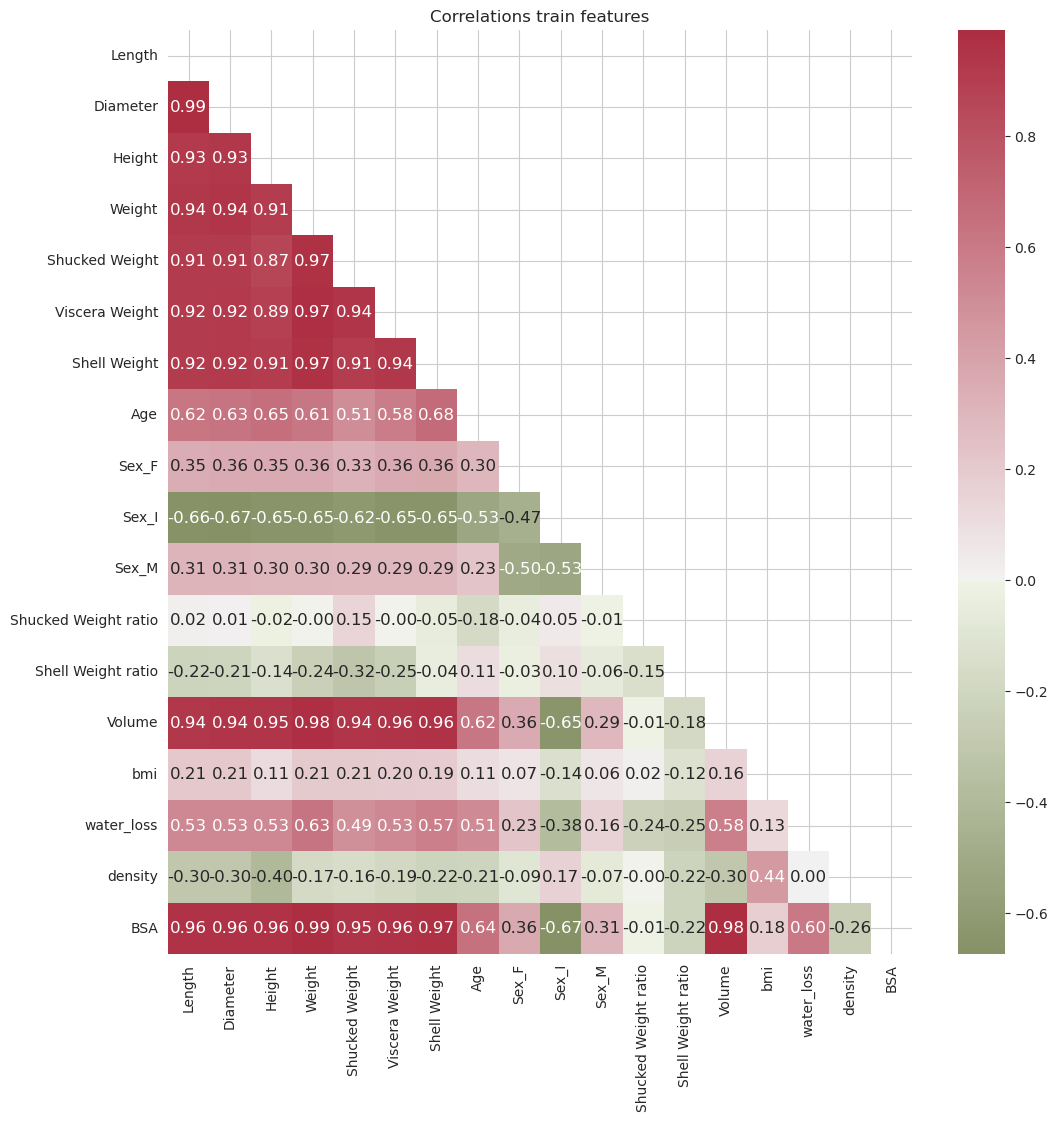

In [34]:
#plot_heatmap(train_eng[numeric_cols + news_cols + [target]], title='Train_eng data')


corr_mat_data = train_eng.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

#fig, axes = plt.subplots(1, 1, figsize = (25, 10))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations train features');

In [35]:
columns_to_drop = ['Sex_I', 'Age']
X = train_eng.drop(columns=columns_to_drop, axis=1)
test_eng = test_eng.drop('Sex_I', axis=1)
Y = train_eng['Age']
Y

0         9.00000
1         8.00000
2         9.00000
3        11.00000
4         8.00000
           ...   
201334   10.00000
201335   10.00000
201336    9.00000
201337    8.00000
201338   13.00000
Name: Age, Length: 201339, dtype: float64

In [36]:
X

Length  Diameter  Height   Weight  Shucked Weight  Viscera Weight  \
0      1.52500   1.17500 0.37500 28.97319        12.72893         6.64796   
1      1.10000   0.82500 0.27500 10.41844         4.52175         2.32466   
2      1.38750   1.11250 0.37500 24.77746        11.33980         5.55650   
3      1.70000   1.41250 0.50000 50.66056        20.35494        10.99184   
4      1.25000   1.01250 0.33750 23.28911        11.97766         4.50757   
...        ...       ...     ...      ...             ...             ...   
201334 1.56250   1.22500 0.46250 32.98464        13.99048         7.25747   
201335 1.65000   1.28750 0.41250 43.82833        19.64620         8.27805   
201336 1.55000   1.25000 0.41250 32.95629        15.56388         6.88893   
201337 1.30000   1.00000 0.30000 16.83960         8.84504         3.72796   
201338 1.62500   1.31250 0.47500 42.82192        16.17339         8.63242   

        Shell Weight  Sex_F  Sex_M  Shucked Weight ratio  Shell Weight ratio  \
0            8.34893      0      0               0.43933             0.28816   
1            3.40194      0      0               0.43401             0.32653   
2            6.66213      0      1               0.45767             0.26888   
3           14.99689      1      0               0.40179             0.29603   
4            5.95340      0      0               0.51430             0.25563   
...              ...    ...    ...                   ...                 ...   
201334       9.49708      1      0               0.42415             0.28792   
201335      10.06407      0      1               0.44825             0.22962   
201336       9.49708      0      1               0.47226             0.28817   
201337       4.79107      0      0               0.52525             0.28451   
201338      11.05631      1      0               0.37769             0.25819   

        Volume       bmi  water_loss  density     BSA  
0      0.67195 206.03157     1.24738 43.11787 0.05102  
1      0.24956 137.76451     0.17010 41.74682 0.02620  
2      0.57885 176.19529     1.21903 42.80481 0.04718  
3      1.20063 202.64223     4.31689 42.19515 0.07791  
4      0.42715 204.45862     0.85049 54.52230 0.04340  
...        ...       ...         ...      ...     ...  
201334 0.88525 154.20140     2.23961 37.26009 0.06046  
201335 0.87630 257.57694     5.84000 50.01494 0.06582  
201336 0.79922 193.68253     1.00641 41.23564 0.05707  
201337 0.39000 187.10670     0.01417 43.17847 0.03479  
201338 1.01309 189.79244     6.95980 42.26879 0.06981  

[201339 rows x 16 columns]

In [37]:
"""#scaling the data
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X))
test_eng = pd.DataFrame(scaler.transform(test_eng))
test_eng"""

'#scaling the data\nscaler = StandardScaler()\n\nX = pd.DataFrame(scaler.fit_transform(X))\ntest_eng = pd.DataFrame(scaler.transform(test_eng))\ntest_eng'

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Scaling : <br>
         As we'll use Gradient Boosting Decision Trees(GBDT) models, so scaling the data might not be necessary.

</b>
</p> 

In [38]:
X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
X_val

Length  Diameter  Height   Weight  Shucked Weight  Viscera Weight  \
67128  1.12500   0.82500 0.25000 12.54465         5.74077         2.55145   
177978 1.62500   1.23750 0.45000 38.83881        17.51999         8.60407   
72357  0.78750   0.56250 0.18750  3.86971         1.53087         0.68039   
106011 1.61250   1.26250 0.50000 40.41221        18.01611         7.20077   
43113  1.31250   0.95000 0.32500 18.58310         9.48291         3.52951   
...        ...       ...     ...      ...             ...             ...   
149013 1.10000   0.85000 0.27500 12.14776         5.32971         2.46641   
2218   1.28750   0.97500 0.30000 16.71203         7.04485         3.71378   
107020 0.67500   0.48750 0.16250  3.67126         1.31825         0.48194   
81194  0.51250   0.38750 0.11250  1.30408         0.66621         0.22680   
188447 1.13750   0.88750 0.26250 12.67223         5.91087         2.29631   

        Shell Weight  Sex_F  Sex_M  Shucked Weight ratio  Shell Weight ratio  \
67128        3.11844      0      0               0.45763             0.24859   
177978      10.34757      0      1               0.45109             0.26642   
72357        1.13398      0      0               0.39560             0.29304   
106011      11.62330      1      0               0.44581             0.28762   
43113        4.96116      0      0               0.51030             0.26697   
...              ...    ...    ...                   ...                 ...   
149013       2.76408      0      0               0.43874             0.22754   
2218         4.73437      0      1               0.42154             0.28329   
107020       0.79379      0      0               0.35907             0.21622   
81194        0.39689      0      1               0.51087             0.30435   
188447       3.54369      0      0               0.46644             0.27964   

        Volume       bmi  water_loss  density     BSA  
67128  0.23203 200.71446     1.13398 54.06450 0.02741  
177978 0.90492 191.79662     2.36718 42.91952 0.06471  
72357  0.08306 110.07166     0.52447 46.59118 0.01319  
106011 1.01789 161.64885     3.57204 39.70192 0.06958  
43113  0.40523 175.93465     0.60951 45.85765 0.03804  
...        ...       ...         ...      ...     ...  
149013 0.25713 160.63155     1.58757 47.24457 0.02829  
2218   0.37659 185.68923     1.21903 44.37681 0.03466  
107020 0.05347 139.02997     1.07728 68.65678 0.01196  
81194  0.02234 103.03818     0.01417 58.36939 0.00593  
188447 0.26500 183.90533     0.92136 47.81937 0.02823  

[20134 rows x 16 columns]

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Models building</p>  

In [39]:
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds   = list(), list()
xgb_cv_scores, xgb_preds   = list(), list()
cat_cv_scores, cat_preds   = list(), list()

ens_cv_scores, ens_preds = list(), list()



imp_hist = pd.DataFrame()
#imp_cat = pd.DataFrame()
imp_xgb = pd.DataFrame()
imp_ens = pd.DataFrame()
imp = pd.DataFrame()

skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('=====================================================================')
    

    #==================================================== LightGBM ==========================================================#
    
    lgb_params = {
                    "objective": "regression_l1", # ="mae"
                    "metric": "mae",
                    "learning_rate": 0.03, # 0.01
                    "n_estimators": 5000,
                    "max_depth": 10,
                    "num_leaves": 255,
                    "reg_alpha": 0.1, 
                    "reg_lambda": 0.1, 
                    "subsample": 0.4 
                }
    
    lgb_md = LGBMRegressor(**lgb_params).fit(X_train, Y_train)

    # Validation
    lgb_pred_1 = lgb_md.predict(X_test)
    lgb_score_fold = mean_absolute_error(Y_test, lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    
    # Prediction
    lgb_pred_2 = lgb_md.predict(test_eng)
    lgb_preds.append(lgb_pred_2)
    
    # Importance
    _imp = pd.DataFrame({"features": X.columns, "importance": lgb_md.feature_importances_})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print('Fold N°', i, '==> LightGBM -          MAE: ====>', lgb_score_fold)

    
    #==================================================== HistGradientBoosting ====================================================#
    
    
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error',
                                            l2_regularization = 0.01,
                                            early_stopping = False,
                                            learning_rate = 0.01,
                                            max_iter = 1000,
                                            max_depth = 15,
                                            max_bins = 255,
                                            min_samples_leaf = 30,
                                            max_leaf_nodes = 30).fit(X_train, Y_train)
   
    # Validation
    hist_pred_1 = hist_md.predict(X_test)
    hist_score_fold = mean_absolute_error(Y_test, hist_pred_1)
    hist_cv_scores.append(hist_score_fold)

    # Prediction
    hist_pred_2 = hist_md.predict(test_eng)
    hist_preds.append(hist_pred_2)
    
    print('Fold N°', i, '==> HistGradient -       MAE: ====>', hist_score_fold)

    
    #======================================================== XGBoost ============================================================#
    

    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror',
                          tree_method = 'hist',
                          colsample_bytree = 0.9, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 7, 
                          min_child_weight = 20, 
                          n_estimators = 5000,
                          subsample = 0.7,
                          random_state = 42).fit(X_train, Y_train,
                                            #eval_set = [(X_train, Y_train), (X_test, Y_test)],
                                            verbose=0
                                            )
    # Validation
    xgb_pred_1 = xgb_md.predict(X_test)
    xgb_score_fold = mean_absolute_error(Y_test, xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)

    # Prediction
    xgb_pred_2 = xgb_md.predict(test_eng)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold N°', i, '==> XGBoost -        MAE: ====>', xgb_score_fold)

    
    #========================================================= CatBoost ========================================================#
   
    
    cat_md = CatBoostRegressor(loss_function = 'MAE',
                               iterations = 1000,
                               learning_rate = 0.03,
                               depth = 10, 
                               random_strength = 0.2,
                               bagging_temperature = 0.7,
                               border_count = 254,
                               l2_leaf_reg = 0.001,
                               verbose = False,
                               grow_policy = 'Lossguide',
                               task_type = 'CPU',
                               random_state = 42).fit(X_train, Y_train)
    
    # Validation
    cat_pred_1 = cat_md.predict(X_test)
    cat_score_fold = mean_absolute_error(Y_test, cat_pred_1)    
    cat_cv_scores.append(cat_score_fold)
    
    # Prediction
    cat_pred_2 = cat_md.predict(test_eng)
    cat_preds.append(cat_pred_2)
    
    print('Fold N°', i, '==> CatBoost       - MAE: ====>', cat_score_fold)

    
    #========================================================= LAD Ensemble =========================================================#
    
    x = pd.DataFrame({'hist': np.round(hist_pred_1.tolist()), 
                      'lgb': np.round(lgb_pred_1.tolist()),
                      'xgb': np.round(xgb_pred_1.tolist()), 
                      'cat': np.round(cat_pred_1.tolist())}
                    )
    y = Y_test
    
    x_test = pd.DataFrame({'hist': np.round(hist_pred_2.tolist()), 
                           'lgb': np.round(lgb_pred_2.tolist()),
                           'xgb': np.round(xgb_pred_2.tolist()), 
                           'cat': np.round(cat_pred_2.tolist())}
                         )
    
    lad_md = LADRegression().fit(x, y)
    
    # Validation
    lad_pred = lad_md.predict(x)     
    ens_score = mean_absolute_error(y, lad_pred)
    ens_cv_scores.append(ens_score)
    
    #Predictions
    lad_pred_test = lad_md.predict(x_test)
    ens_preds.append(lad_pred_test)
    
    print('Fold N°', i, '==> LAD Model 1 ensemble - MAE: ====>', ens_score)

Fold N° 0 ==> LightGBM -          MAE: ====> 1.326419115006223
Fold N° 0 ==> HistGradient -       MAE: ====> 1.3334666257756231
Fold N° 0 ==> XGBoost -        MAE: ====> 1.332247520583821
Fold N° 0 ==> CatBoost       - MAE: ====> 1.319605689986674
Fold N° 0 ==> LAD Model 1 ensemble - MAE: ====> 1.3059999535198556
Fold N° 1 ==> LightGBM -          MAE: ====> 1.3159534452578903
Fold N° 1 ==> HistGradient -       MAE: ====> 1.3189803482779308
Fold N° 1 ==> XGBoost -        MAE: ====> 1.3192976549441278
Fold N° 1 ==> CatBoost       - MAE: ====> 1.305081948750558
Fold N° 1 ==> LAD Model 1 ensemble - MAE: ====> 1.2875117267318599
Fold N° 2 ==> LightGBM -          MAE: ====> 1.3413756114783484
Fold N° 2 ==> HistGradient -       MAE: ====> 1.3457297865814144
Fold N° 2 ==> XGBoost -        MAE: ====> 1.3424577811558867
Fold N° 2 ==> CatBoost       - MAE: ====> 1.3297954744459715
Fold N° 2 ==> LAD Model 1 ensemble - MAE: ====> 1.315104024506352
Fold N° 3 ==> LightGBM -          MAE: ====> 1.3103

In [40]:
# Display important features for LGBMRegressor
imp = imp.groupby("features")["importance"].agg(["mean", "std"])
imp.columns = ["importance", "importance_std"]
imp["importance_cov"] = imp["importance_std"] / imp["importance"]
imp = imp.reset_index(drop=False)
display(imp.sort_values("importance", ascending=False, ignore_index=True))

features  importance  importance_std  importance_cov
0   Shucked Weight ratio 80209.70000     19247.98915         0.23997
1                density 72637.40000     13855.89523         0.19075
2     Shell Weight ratio 72609.50000     11893.62078         0.16380
3             water_loss 65020.50000     11879.34052         0.18270
4                    bmi 63115.00000     13662.19251         0.21647
5         Viscera Weight 60171.40000     11098.14504         0.18444
6           Shell Weight 50528.40000      8231.87118         0.16292
7                 Length 45835.60000      8342.82022         0.18202
8         Shucked Weight 44487.50000      8605.93753         0.19345
9               Diameter 39939.80000      8543.11160         0.21390
10                Volume 35629.00000      5180.70444         0.14541
11                   BSA 29557.30000      4623.31819         0.15642
12                Weight 28873.20000      3792.03970         0.13133
13                Height 21974.20000      2390.26525         0.10878
14                 Sex_M  7265.50000      5419.72124         0.74595
15                 Sex_F  5855.80000      1999.51315         0.34146

In [41]:
lgb_cv_score = np.mean(lgb_cv_scores)
print(f"Score on CV test data             ======> {lgb_cv_score}")
preds_val = lgb_md.predict(X_val)
preds_val_score = mean_absolute_error(Y_val, preds_val)
print(f"Score on Valid data (unseen data) ======> {preds_val_score}")

Score on CV test data             ======> 1.3257865607183885
Score on Valid data (unseen data) ======> 1.331781911945371


In [42]:
# HistGB scores

hist_cv_score = np.mean(hist_cv_scores)
print(f"Score on CV test data             ======> {hist_cv_score}")

hist_preds_val = hist_md.predict(X_val)
hist_preds_val_score = mean_absolute_error(Y_val, hist_preds_val)
print(f"Score on Valid data (unseen data) ======> {hist_preds_val_score}")

Score on CV test data             ======> 1.3290830147485084
Score on Valid data (unseen data) ======> 1.3386263891457815


In [43]:
# XGBoost scores

xgb_cv_score = np.mean(xgb_cv_scores)
print(f"Score on CV test data             ======> {xgb_cv_score}")

xgb_preds_val = xgb_md.predict(X_val)
xgb_preds_val_score = mean_absolute_error(Y_val, xgb_preds_val)
print(f"Score on Valid data (unseen data) ======> {xgb_preds_val_score}")

Score on CV test data             ======> 1.3290067560715002
Score on Valid data (unseen data) ======> 1.3367127887752923


<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Saving the models : <br>
        We can use joblib to save the models we trained so we can use them later if needed.

</b>
</p> 

In [44]:
"""from joblib import dump, load
dump(lgb_md, 'lgb_md.joblib') 
dump(hist_md, 'hist_md.joblib') 
dump(xgb_md, 'xgb_md.joblib') 
dump(lad_md, 'lad_md.joblib') """

"from joblib import dump, load\ndump(lgb_md, 'lgb_md.joblib') \ndump(hist_md, 'hist_md.joblib') \ndump(xgb_md, 'xgb_md.joblib') \ndump(lad_md, 'lad_md.joblib') "

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Submissions</p>  

In [45]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e16/sample_submission.csv")

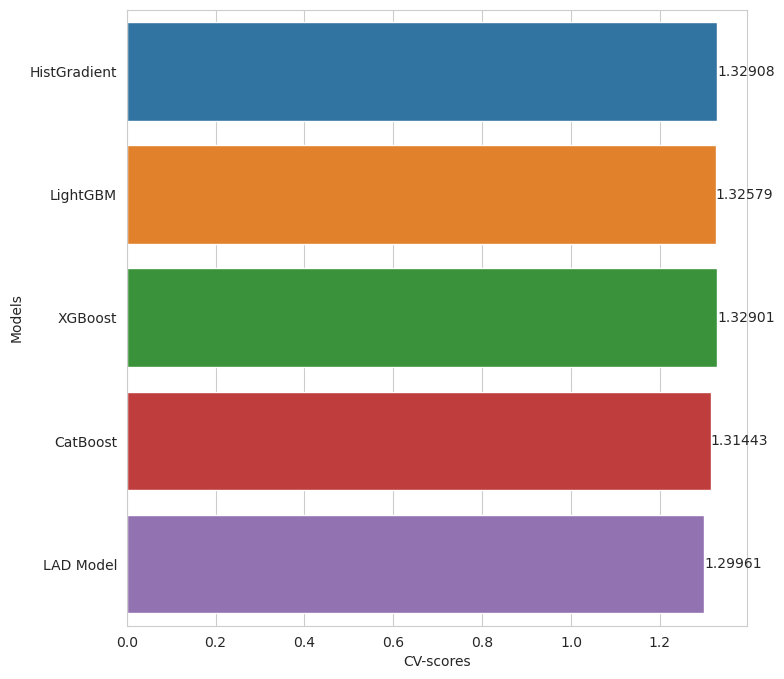

In [46]:
# Visualize models performances
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
cat_cv_score = np.mean(cat_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)


model_perf = pd.DataFrame({'Models': [ 'HistGradient' ,'LightGBM', 'XGBoost', 'CatBoost', 'LAD Model'],
                           'CV-scores': [ hist_cv_score, lgb_cv_score, xgb_cv_score, cat_cv_score, ens_cv_score]
                          })

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Models', x = 'CV-scores', data = model_perf)
ax.bar_label(ax.containers[0]);

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡mattop_post_process function: <br>
        The following function takes a list of predictions and returns an array of target values by calculating the absolute difference between each prediction and all target values, and then selects the target value with the smallest difference for each prediction.
        

</b>
</p> 

In [47]:
unique_targets = np.unique(train['Age'])
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [48]:
ens_preds_test = mattop_post_process(pd.DataFrame(ens_preds).apply(np.mean, axis = 0))

submission['Age'] = ens_preds_test.astype(int)
submission.to_csv('LAD_model.csv', index = False)

# <p style="padding:15px; background-color:#E55807; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Ressources</p>  

Synthetic Dataset used: [link](https://www.kaggle.com/datasets/e271828ai/ps-s3-e16-synthetic-train-data); Generated by [Make Synthetic Crab Age Data](https://www.kaggle.com/code/inversion/make-synthetic-crab-age-data/notebook) with changing parameters.

For more details about univariate and bivariate statistics, check [this article](https://www.analyticsvidhya.com/blog/2021/04/exploratory-analysis-using-univariate-bivariate-and-multivariate-analysis-techniques/)

The functions of some graphics used above are inspired from this great [notebook](https://www.kaggle.com/code/tetsutani/ps3e16-eda-ensemble-ml-pipeline)

The idea of using RandomForestRegressor to predict Height null values come from this [notebook](https://www.kaggle.com/code/e271828ai/ps-s3-e16-basicapproach-20230601)

The modeling part is inspired from [this excellent notebook](https://www.kaggle.com/code/oscarm524/ps-s3-ep16-eda-modeling-submission).

See more details about the mattop_post_process function in [this discussion](https://www.kaggle.com/competitions/playground-series-s3e14/discussion/407327)

<p style="padding:15px; background-color:#E55807; font-weight:bold; color:#FFD700; font-size:100%; border-radius: 15px 15px;">
    <b>💡I didn't make any hyperparameters tuning in this notebook because of a time problem. Obviously this would increase performance. <br/>
        Please leave your valuable reviews in the comment section. <br/><br/>
        Best regards.
</b>
</p> 